In [0]:
import pandas as pd
import numpy as np

import teradatasql

import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
from statsmodels.tsa.stattools import adfuller
import itertools
import optuna
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings("ignore")

In [0]:
# Create widget
# dbutils.widgets.text("Style","RB103+SSLSETRMCBT00004")

In [0]:
#Get widget
Style = dbutils.widgets.get("Style")
Style

"'RB101','SSLSETRMCBT00003'"

#Reading Data from Teradata

In [0]:
%%time
query = f'''
        select s.sls_date, s.GSV, s.SLS_MRP, sum(s.sls_qty),s.site_code, a.Option_code, st.site_zone
        from pfrl_it.sls_summary_v as s
        left join pfrl_it.sls_marticle as a on s.article_code=a.article_code 
        left join pfrl_it.sls_marticlehierarchy as h on a.mc_code=h.mc_code
        inner join pfrl_it.sls_msite as st on s.site_code=st.site_code 
        where a.Style in({Style})  
        and h.new_mc_product_class in ('CORE', 'C/CP')
        and st.concept in ('PT','PW','PK')
        and h.mc_type in ('PT')
        and s.bill_type in ('ZPOS','ZRMS','ZBOS','ZOMB','ZOMS','ZBMS') 
        and h.new_world in ('ETHNIC APPAREL')
        group by s.sls_date, s.GSV, s.SLS_MRP,s.site_code, a.Option_code, st.site_zone;
              
        '''
with teradatasql.connect(host='10.150.9.10', user='Swayam Sharma', password='Abfls@123') as connect:
        df = pd.read_sql(query,connect)

CPU times: user 5.09 s, sys: 584 ms, total: 5.67 s
Wall time: 22.9 s


In [0]:
df

,SLS_Date,GSV,SLS_MRP,SLS_Qty,Site_Code,Option_Code,Site_Zone
0,2022-08-14,799.00,799.0,1.0,P126,110121651INDIGO,EAST
1,2023-10-24,799.00,799.0,1.0,P680,110137145GOLD,SOUTH
2,2024-05-05,719.10,799.0,1.0,P006,110137145OFFWHITE,EAST
3,2023-06-03,799.00,799.0,1.0,P306,110121651BLACK,NORTH
4,2024-02-19,799.00,799.0,1.0,P103,110137145RED,SOUTH
...,...,...,...,...,...,...,...
145152,2022-09-30,719.10,799.0,1.0,P615,110121651BLACK,SOUTH
145153,2024-05-01,799.00,799.0,1.0,P502,110137145CHARCOAL,SOUTH
145154,2023-12-20,503.37,799.0,1.0,P192,110117431BLACK,NORTH
145155,2021-03-19,799.00,799.0,1.0,P048,110095982CORAL,WEST


In [0]:
sales_df = df.copy()
sales_df['SLS_Date'] = pd.to_datetime(sales_df['SLS_Date'])
sales_df.sort_values(by=['SLS_Date'], inplace =True)
sales_df['MD'] = round(((sales_df['SLS_MRP'] - sales_df['GSV'])/sales_df['SLS_MRP'])*100)
sales_df.drop(['SLS_MRP', 'GSV'], inplace=True, axis=1)
sales_df['MD'] = sales_df['MD'].apply(lambda x: 0 if x<0 else x)
sales_df['MD'] = sales_df['MD'].apply(lambda x: 0 if x>100 else x)
sales_df.set_index('SLS_Date',inplace=True)

In [0]:
sales_df

,SLS_Qty,Site_Code,Option_Code,Site_Zone,MD
SLS_Date,,,,,
2021-01-16,1.0,P243,110095982CHARCOAL,SOUTH,0.0
2021-01-17,1.0,P382,110095982CHARCOAL,SOUTH,0.0
2021-01-18,1.0,P071,110095982RED,EAST,0.0
2021-01-19,1.0,P420,110095982CORAL,SOUTH,0.0
2021-01-20,1.0,W014,110095982CORAL,SOUTH,0.0
...,...,...,...,...,...
2024-07-02,1.0,P032,110137145BLACK,SOUTH,10.0
2024-07-02,1.0,P305,110137145WHITE,SOUTH,0.0
2024-07-02,3.0,P058,110137145BLACK,WEST,0.0


In [0]:
monthly_df = sales_df.resample('M').agg({'SLS_Qty': 'sum'})
monthly_df

,SLS_Qty
SLS_Date,
2021-01-31,200.0
2021-02-28,654.0
2021-03-31,2424.0
2021-04-30,2035.0
2021-05-31,181.0
2021-06-30,1003.0
2021-07-31,2003.0
2021-08-31,2088.0
2021-09-30,2394.0


<Axes: xlabel='SLS_Date'>

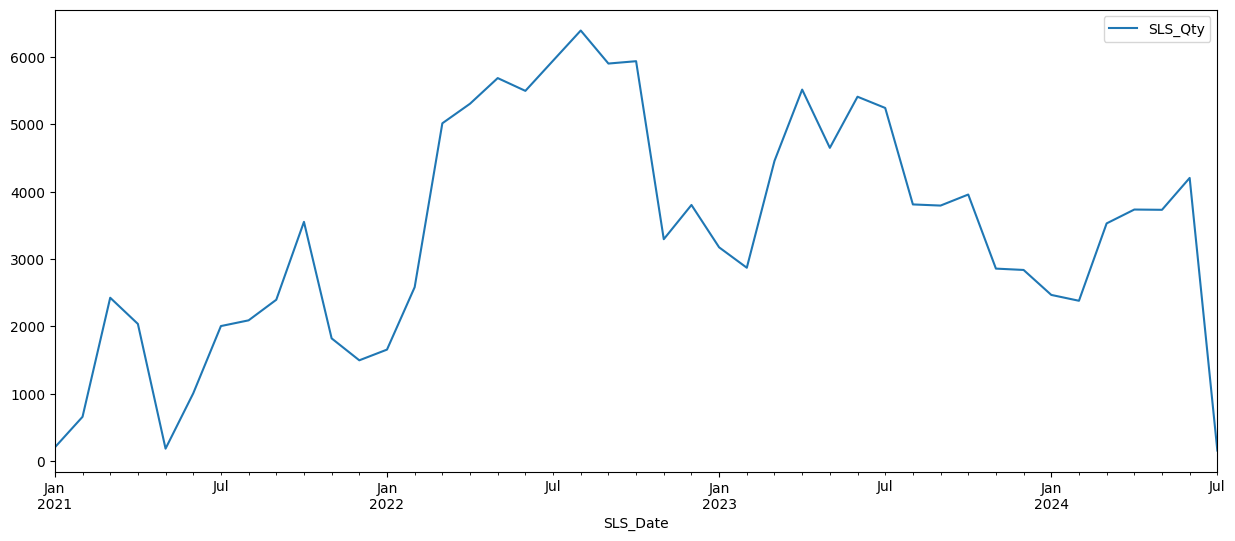

In [0]:
## Checking for trends
monthly_df.plot(figsize=(15,6))

In [0]:
# for zone in ['NORTH', 'SOUTH', 'EAST', 'WEST']:
#   month_df = sales_df[sales_df['Site_Zone']==zone]
#   month_df = month_df.resample('M').agg({'Site_Code': 'nunique'})
#   month_df.rename(columns={f'Site_Code': f'Site_Code_{zone}'}, inplace=True)
#   monthly_df = monthly_df.reset_index()
#   month_df = month_df.reset_index()
#   monthly_df = monthly_df.merge(month_df, on = 'SLS_Date', how='left')
#   if zone != 'NORTH': 
#     monthly_df.drop(['index'], inplace = True, axis=1)
# monthly_df.set_index('SLS_Date',inplace=True)


In [0]:
month_df = sales_df.resample('M').agg({'Site_Code': 'nunique','Option_Code': 'nunique'})
monthly_df = monthly_df.reset_index()
month_df = month_df.reset_index()
monthly_df = monthly_df.merge(month_df, on = 'SLS_Date', how='left')
monthly_df.set_index('SLS_Date',inplace=True)

In [0]:
monthly_df

,SLS_Qty,Site_Code,Option_Code
SLS_Date,,,
2021-01-31,200.0,75,4
2021-02-28,654.0,175,4
2021-03-31,2424.0,301,9
2021-04-30,2035.0,285,9
2021-05-31,181.0,87,9
2021-06-30,1003.0,234,9
2021-07-31,2003.0,281,9
2021-08-31,2088.0,308,12
2021-09-30,2394.0,313,14


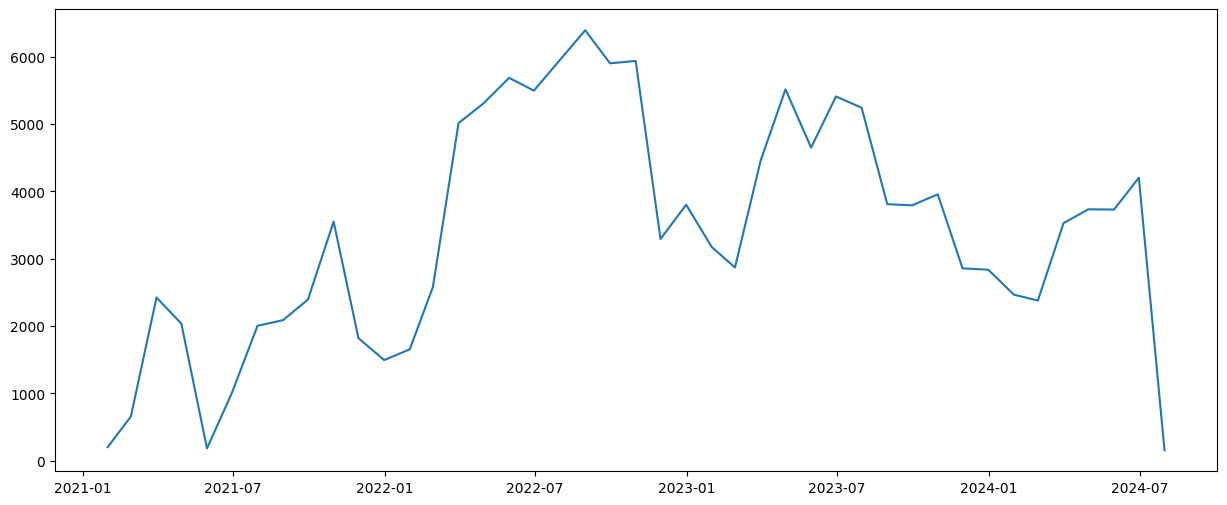

In [0]:
plt.figure(figsize=(15,6))
plt.plot(monthly_df.index,monthly_df['SLS_Qty'])

In [0]:
# eoss_df = pd.DataFrame({'SLS_Date':pd.date_range(start='2019-03-01',end='2024-07-31',)})

# eoss = pd.read_csv('/Workspace/Repos/Abfrl_Analytics/Scripts/Customer_Analytics/Development/Pantaloons_Sales_Forecasting/Bottom Up/Nikhil/EOSS_Dates.csv')
# eoss.columns = ['date','EOSS']
# eoss['date'] = pd.to_datetime(eoss['date'])
# eoss=eoss[eoss['date']>='2018-01-01']

# eoss_df = (eoss_df.merge(eoss, left_on='SLS_Date', right_on='date',how='left'))
# eoss_df.drop('date',inplace=True,axis=1)
# eoss_df['EOSS'] = eoss_df['EOSS'].fillna(0)
# eoss_df.set_index('SLS_Date',inplace=True)
# # eoss_df['EOSS'][(eoss_df.index.year==2023) & (eoss_df.index.month==7)] = 1
# eoss_df.loc[(eoss_df.index >= '2023-06-28') & (eoss_df.index <= '2023-07-31'), 'EOSS'] = 1
# eoss_df.loc[(eoss_df.index >= '2023-12-15') & (eoss_df.index <= '2024 '), 'EOSS'] = 1
# eoss_df.loc[(eoss_df.index >= '2024-06-28') & (eoss_df.index <= '2024-07-31'), 'EOSS'] = 1

In [0]:
# Load EOSS data from the CSV file
eoss = pd.read_csv('/Workspace/Repos/Abfrl_Analytics/Scripts/Customer_Analytics/Development/Pantaloons_Sales_Forecasting/Bottom Up/Nikhil/EOSS_Dates.csv')
eoss.columns = ['date', 'EOSS']
eoss['date'] = pd.to_datetime(eoss['date'])
eoss = eoss[eoss['date'] >= '2018-01-01']

# Create a DataFrame for the entire range of dates
eoss_df = pd.DataFrame({'SLS_Date': pd.date_range(start=sales_df.index[0], end='2025-03-31')})

# Merge EOSS data with the date range DataFrame
eoss_df = eoss_df.merge(eoss, left_on='SLS_Date', right_on='date', how='left')
eoss_df.drop('date', inplace=True, axis=1)
eoss_df['EOSS'] = eoss_df['EOSS'].fillna(0)
eoss_df.set_index('SLS_Date', inplace=True)

eoss_df.loc[(eoss_df.index >= '2023-06-28') & (eoss_df.index <= '2023-07-31'), 'EOSS'] = 1
eoss_df.loc[(eoss_df.index >= '2023-12-15') & (eoss_df.index <= '2024-01-28'), 'EOSS'] = 1
eoss_df.loc[(eoss_df.index >= '2024-06-28') & (eoss_df.index <= '2024-07-31'), 'EOSS'] = 1

# # Set EOSS to 1 for specific date ranges for EOSS winter and summer
# eoss_df['EOSS_winter'] = 0
# eoss_df.loc[(eoss_df['EOSS'] == 1) & ((eoss_df.index.month ==12) | (eoss_df.index.month ==1)), 'EOSS_winter'] = 1
# eoss_df['EOSS_summer'] = 0
# eoss_df.loc[(eoss_df['EOSS'] == 1) & ((eoss_df.index.month == 6) | (eoss_df.index.month == 7)), 'EOSS_summer'] = 1

eoss_df.drop('EOSS', axis=1, inplace= True)

In [0]:
def is_covid(dt):
    year_month={
    2020:[3,4,5,6,7],
    2021:[4,5,6,7],
    }

    if year_month.get(dt.year) and dt.month in year_month.get(dt.year):
        return 1
    return 0
eoss_df['covid'] = eoss_df.index.map(lambda dt:is_covid(dt))

In [0]:
eoss_df

,covid
SLS_Date,
2021-01-16,0
2021-01-17,0
2021-01-18,0
2021-01-19,0
2021-01-20,0
...,...
2025-03-27,0
2025-03-28,0
2025-03-29,0


In [0]:
def create_regressor_for_festival(sales_df, festive_periods, festival_name, days_before):
    regressor_dates = []
    for year, (festival_start, festival_end) in festive_periods.items():
        regressor_dates.extend(pd.date_range(start=festival_start - pd.DateOffset(days=days_before), end=festival_end, freq='D'))
    
    regressor_df = pd.DataFrame({'Date': regressor_dates})
    regressor_df[f'{festival_name}_regressor'] = 1
    regressor_df.set_index('Date', inplace=True)        
    
    sales_df[f'{festival_name}_regressor'] = sales_df['SLS_Date'].map(regressor_df[f'{festival_name}_regressor'])
    sales_df[f'{festival_name}_regressor'].fillna(0, inplace=True)
    
    return sales_df

In [0]:
shraad_periods = {
    2018: (pd.Timestamp('2018-09-24'), pd.Timestamp('2018-10-08')),
    2019: (pd.Timestamp('2019-09-13'), pd.Timestamp('2019-09-28')),
    2020: (pd.Timestamp('2020-09-01'), pd.Timestamp('2020-09-17')),
    2021: (pd.Timestamp('2021-09-20'), pd.Timestamp('2021-10-06')),
    2022: (pd.Timestamp('2022-09-10'), pd.Timestamp('2022-09-25')),
    2023: (pd.Timestamp('2023-09-29'), pd.Timestamp('2023-10-14')),
    2024: (pd.Timestamp('2024-09-17'), pd.Timestamp('2024-10-02'))
}

navratri_periods = {
    2018: (pd.Timestamp('2018-10-10'), pd.Timestamp('2018-10-19')),
    2019: (pd.Timestamp('2019-09-29'), pd.Timestamp('2019-10-08')),
    2020: (pd.Timestamp('2020-10-17'), pd.Timestamp('2020-10-25')),
    2021: (pd.Timestamp('2021-10-07'), pd.Timestamp('2021-10-15')),
    2022: (pd.Timestamp('2022-09-26'), pd.Timestamp('2022-10-05')),
    2023: (pd.Timestamp('2023-10-15'), pd.Timestamp('2023-10-24')),
    2024: (pd.Timestamp('2024-10-03'), pd.Timestamp('2024-10-12'))
}

diwali_periods = {
    2018: (pd.Timestamp('2018-11-05'), pd.Timestamp('2018-11-09')),
    2019: (pd.Timestamp('2019-10-25'), pd.Timestamp('2019-10-29')),
    2020: (pd.Timestamp('2020-11-13'), pd.Timestamp('2020-11-16')),
    2021: (pd.Timestamp('2021-11-02'), pd.Timestamp('2021-11-06')),
    2022: (pd.Timestamp('2022-10-22'), pd.Timestamp('2022-10-26')),
    2023: (pd.Timestamp('2023-11-10'), pd.Timestamp('2023-11-14')),
    2024: (pd.Timestamp('2024-10-29'), pd.Timestamp('2024-11-03'))
}

In [0]:
eoss_df = eoss_df.reset_index()
eoss_df = create_regressor_for_festival(eoss_df, diwali_periods, 'Diwali', 14)
eoss_df = create_regressor_for_festival(eoss_df, navratri_periods, 'Navratri', 7)
eoss_df = create_regressor_for_festival(eoss_df, shraad_periods, 'Shraad', 7)

In [0]:
eoss_df[eoss_df['SLS_Date']>='2023-10-10'].head(20)

,SLS_Date,covid,Diwali_regressor,Navratri_regressor,Shraad_regressor
997,2023-10-10,0,0.0,1.0,1.0
998,2023-10-11,0,0.0,1.0,1.0
999,2023-10-12,0,0.0,1.0,1.0
1000,2023-10-13,0,0.0,1.0,1.0
1001,2023-10-14,0,0.0,1.0,1.0
1002,2023-10-15,0,0.0,1.0,0.0
1003,2023-10-16,0,0.0,1.0,0.0
1004,2023-10-17,0,0.0,1.0,0.0
1005,2023-10-18,0,0.0,1.0,0.0
1006,2023-10-19,0,0.0,1.0,0.0


In [0]:
# from datetime import datetime

# def is_festive(dt):
#     if isinstance(dt, int):
#         dt = datetime.fromtimestamp(dt)
    
#     year_month = {
#         2018: [10, 11],
#         2019: [9, 10],
#         2020: [10, 11],
#         2021: [10, 11],
#         2022: [9, 10],
#         2023: [10, 11],
#         2024: [9, 10]
#     }

#     if year_month.get(dt.year) and dt.month in year_month.get(dt.year):
#         return 1
#     return 0

# eoss_df['Festive'] = eoss_df.index.map(lambda dt: is_festive(dt))

In [0]:
eoss_df['Weekend_regressor'] = (eoss_df['SLS_Date'].dt.dayofweek >= 5).astype(int)

In [0]:
eoss_df.set_index('SLS_Date', inplace=True)
eoss_df = eoss_df.resample('M').sum()

In [0]:
eoss_df.head(10)

,covid,Diwali_regressor,Navratri_regressor,Shraad_regressor,Weekend_regressor
SLS_Date,,,,,
2021-01-31,0,0.0,0.0,0.0,6
2021-02-28,0,0.0,0.0,0.0,8
2021-03-31,0,0.0,0.0,0.0,8
2021-04-30,30,0.0,0.0,0.0,8
2021-05-31,31,0.0,0.0,0.0,10
2021-06-30,30,0.0,0.0,0.0,8
2021-07-31,31,0.0,0.0,0.0,9
2021-08-31,0,0.0,0.0,0.0,9
2021-09-30,0,0.0,1.0,18.0,8


In [0]:
# eoss_df['EOSS'] = np.round(eoss_df['EOSS']/eoss_df.index.day,2)
# eoss_df['covid'] = np.round(eoss_df['covid']/eoss_df.index.day,2)
# eoss_df['Festive'] = np.round(eoss_df['Festive']/eoss_df.index.day,2)

In [0]:
monthly_grouped_df = (eoss_df.merge(monthly_df, right_on='SLS_Date', left_on=eoss_df.index ,how='left'))

In [0]:
monthly_grouped_df.set_index('SLS_Date', inplace=True)

In [0]:
monthly_grouped_df

,covid,Diwali_regressor,Navratri_regressor,Shraad_regressor,Weekend_regressor,SLS_Qty,Site_Code,Option_Code
SLS_Date,,,,,,,,
2021-01-31,0,0.0,0.0,0.0,6,200.0,75.0,4.0
2021-02-28,0,0.0,0.0,0.0,8,654.0,175.0,4.0
2021-03-31,0,0.0,0.0,0.0,8,2424.0,301.0,9.0
2021-04-30,30,0.0,0.0,0.0,8,2035.0,285.0,9.0
2021-05-31,31,0.0,0.0,0.0,10,181.0,87.0,9.0
2021-06-30,30,0.0,0.0,0.0,8,1003.0,234.0,9.0
2021-07-31,31,0.0,0.0,0.0,9,2003.0,281.0,9.0
2021-08-31,0,0.0,0.0,0.0,9,2088.0,308.0,12.0
2021-09-30,0,0.0,1.0,18.0,8,2394.0,313.0,14.0


In [0]:
grouped_df = monthly_grouped_df[monthly_grouped_df.index >= '2021-08-01']
grouped_df

,covid,Diwali_regressor,Navratri_regressor,Shraad_regressor,Weekend_regressor,SLS_Qty,Site_Code,Option_Code
SLS_Date,,,,,,,,
2021-08-31,0,0.0,0.0,0.0,9,2088.0,308.0,12.0
2021-09-30,0,0.0,1.0,18.0,8,2394.0,313.0,14.0
2021-10-31,0,13.0,15.0,6.0,10,3552.0,335.0,14.0
2021-11-30,0,6.0,0.0,0.0,8,1820.0,321.0,14.0
2021-12-31,0,0.0,0.0,0.0,8,1494.0,300.0,21.0
2022-01-31,0,0.0,0.0,0.0,10,1653.0,296.0,23.0
2022-02-28,0,0.0,0.0,0.0,8,2581.0,344.0,23.0
2022-03-31,0,0.0,0.0,0.0,8,5017.0,355.0,23.0
2022-04-30,0,0.0,0.0,0.0,9,5308.0,368.0,28.0


In [0]:
def fill_future_with_avg(df):
    col_name = df.index[0]
    if pd.isna(df[col_name]):
      current_month = df.name.strftime('%m')
      return (grouped_df[grouped_df[col_name].index.strftime('%m')==current_month][col_name][:-1].mean())
    else:
      return df[0]

In [0]:
# col_fill = ['Site_Code_NORTH', 'Site_Code_SOUTH', 'Site_Code_EAST', 'Site_Code_WEST']


col_fill = ['Site_Code','Option_Code']


In [0]:
for cols in col_fill:
  monthly_grouped_df[cols] = monthly_grouped_df[[cols]].apply(fill_future_with_avg, axis=1)

In [0]:
monthly_grouped_df.fillna(0, inplace= True)

In [0]:
monthly_grouped_df.tail(20)

,covid,Diwali_regressor,Navratri_regressor,Shraad_regressor,Weekend_regressor,SLS_Qty,Site_Code,Option_Code
SLS_Date,,,,,,,,
2023-08-31,0,0.0,0.0,0.0,8,3811.0,420.000000,44.000000
2023-09-30,0,0.0,0.0,9.0,9,3794.0,416.000000,47.000000
2023-10-31,0,5.0,17.0,14.0,9,3958.0,423.000000,43.000000
2023-11-30,0,14.0,0.0,0.0,8,2857.0,412.000000,43.000000
2023-12-31,0,0.0,0.0,0.0,10,2837.0,399.000000,46.000000
2024-01-31,0,0.0,0.0,0.0,8,2466.0,381.000000,45.000000
2024-02-29,0,0.0,0.0,0.0,8,2379.0,384.000000,37.000000
2024-03-31,0,0.0,0.0,0.0,10,3529.0,404.000000,38.000000
2024-04-30,0,0.0,0.0,0.0,8,3735.0,402.000000,37.000000


## SARIMAX

In [0]:
#Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(monthly_grouped_df['SLS_Qty'][:-10], autolag= 'AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                 -2.462112
p-value                         0.124967
#Lags Used                      0.000000
Number of Observations Used    40.000000
Critical Value (1%)            -3.605565
Critical Value (5%)            -2.937069
Critical Value (10%)           -2.606986
dtype: float64


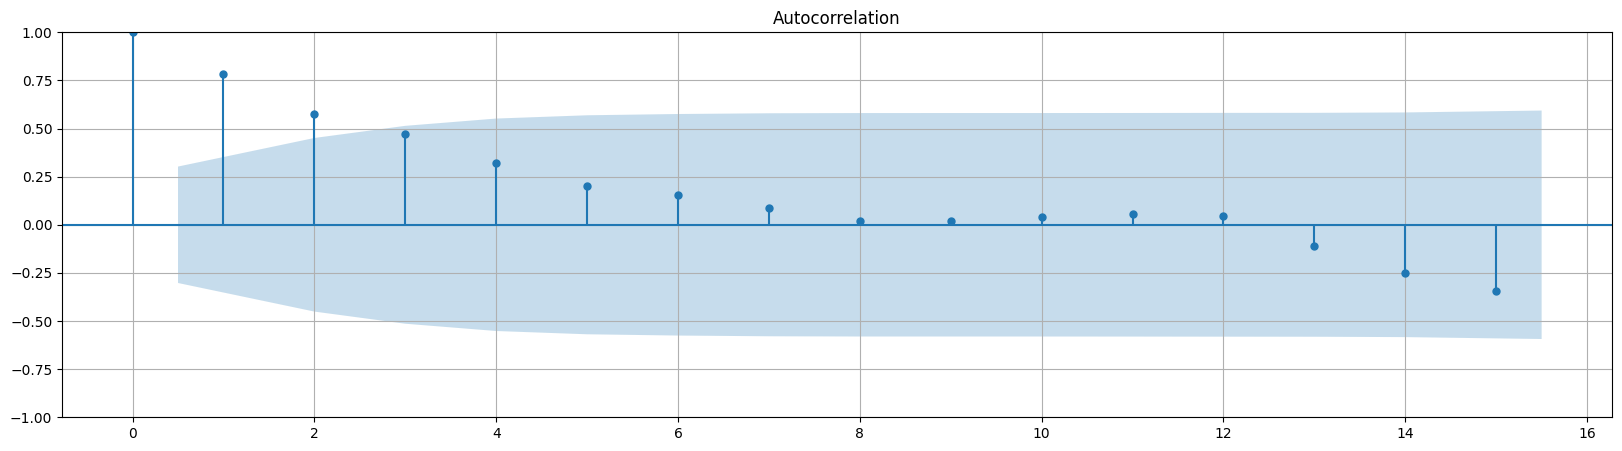

In [0]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(20,5))
plt.grid()
plot_acf(monthly_grouped_df['SLS_Qty'][:-9], ax=plt.gca(), lags = 15)
plt.show()

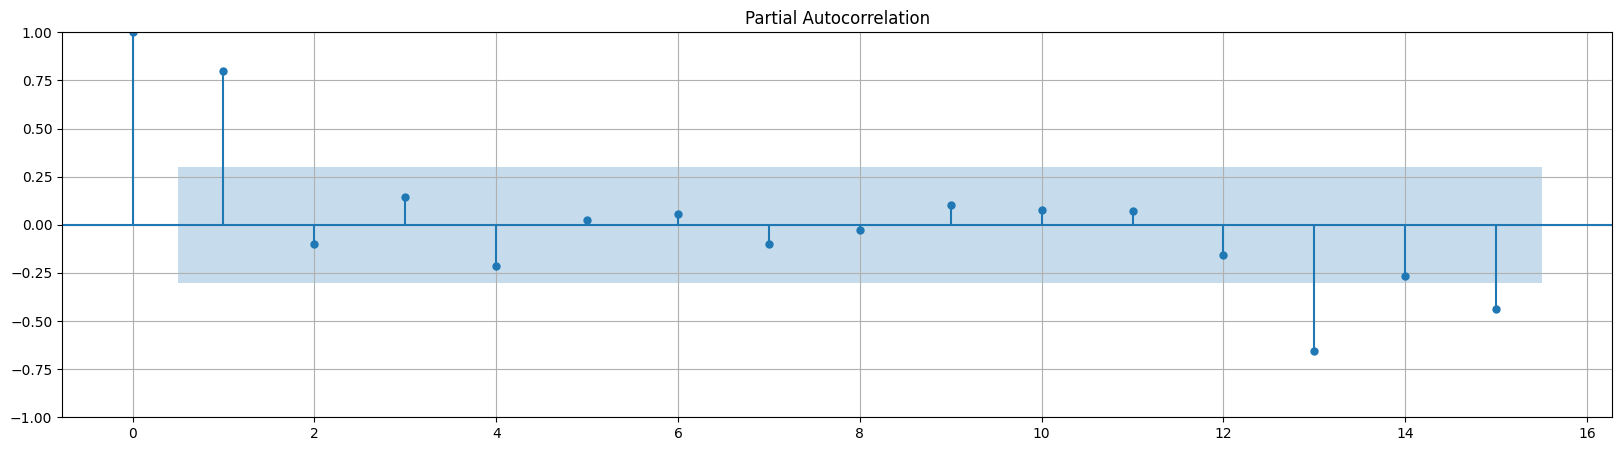

In [0]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(20,5))
plt.grid()
plot_pacf(monthly_grouped_df['SLS_Qty'][:-9], ax=plt.gca(), lags = 15)
plt.show()

In [0]:
monthly_df = monthly_grouped_df[['SLS_Qty']]
regressors_df = monthly_grouped_df.drop('SLS_Qty', axis=1)

In [0]:
# Split data into train / test sets ### from May to Oct --> Nov
sales_train,sales_test = monthly_df[monthly_df.index<='2024-02-29'],monthly_df[monthly_df.index>'2024-02-29']
reg_train,reg_test = regressors_df[regressors_df.index<='2024-02-29'],regressors_df[regressors_df.index>'2024-02-29']

## Optuna to find Best Order

In [0]:
## Testing Dataset
reg_test_optuna = reg_test[reg_test.index <= '2024-06-30']
sales_test_optuna = sales_test[sales_test.index <= '2024-06-30']

In [0]:
p = q = range(0, 4)
d = range(0, 2)
pdq = list(itertools.product(p, d, q))
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [0]:
%%time
def objective_sarima(trial):
    order=trial.suggest_categorical('order',pdq)
    seasonal_order=trial.suggest_categorical('seasonal_order',pdqs)
    model = SARIMAX(sales_train['SLS_Qty'], 
                order = order, 
                seasonal_order = seasonal_order,
                exog = reg_train
                ).fit()
    start = len(sales_train)
    end = len(sales_train) + 3
      
    predictions = model.predict(start, end,
                                  typ = 'levels', exog = reg_test_optuna).to_frame()

    residuals = np.abs(sales_test_optuna['SLS_Qty'] - predictions['predicted_mean']).to_frame()
    mape  = (residuals[0]/sales_test_optuna['SLS_Qty'])*100
    mape=mape.mean()
    return mape
study=optuna.create_study(direction="minimize")
study.optimize(objective_sarima,n_trials=100)

[I 2024-07-03 11:04:50,211] A new study created in memory with name: no-name-4c525aa7-6341-4736-b9d7-2444d574017b
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.73679D+00    |proj g|=  2.19579D-01

At iterate    5    f=  7.70425D+00    |proj g|=  6.53332D-03

At iterate   10    f=  7.69664D+00    |proj g|=  3.40467D-02

At iterate   15    f=  7.69493D+00    |proj g|=  1.11561D-02

At iterate   20    f=  7.69143D+00    |proj g|=  7.38682D-03

At iterate   25    f=  7.68716D+00    |proj g|=  1.61872D-02

At iterate   30    f=  7.67862D+00    |proj g|=  3.22141D-03

At iterate   35    f=  7.67846D+00    |proj g|=  6.35941D-03

At iterate   40    f=  7.67762D+00    |proj g|=  2.12648D-03

At iterate   45    f=  7.67720D+00    |proj g|=  3.50847D-03


[I 2024-07-03 11:04:51,877] Trial 0 finished with value: 5.997506916672669 and parameters: {'order': (3, 1, 1), 'seasonal_order': (2, 0, 2, 12)}. Best is trial 0 with value: 5.997506916672669.



At iterate   50    f=  7.67518D+00    |proj g|=  6.62358D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     56      1     0     0   6.624D-03   7.675D+00
  F =   7.6751792089316861     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.73924D+00    |proj g|=  2.30229D-01


 This problem is unconstrained.



At iterate    5    f=  7.70304D+00    |proj g|=  7.25358D-03

At iterate   10    f=  7.69839D+00    |proj g|=  2.02288D-02

At iterate   15    f=  7.69708D+00    |proj g|=  4.00530D-03

At iterate   20    f=  7.69690D+00    |proj g|=  1.06511D-03

At iterate   25    f=  7.69669D+00    |proj g|=  1.08311D-02

At iterate   30    f=  7.69642D+00    |proj g|=  2.24482D-03

At iterate   35    f=  7.69546D+00    |proj g|=  6.92971D-03

At iterate   40    f=  7.69319D+00    |proj g|=  3.30389D-03

At iterate   45    f=  7.69221D+00    |proj g|=  6.55400D-03


[I 2024-07-03 11:04:54,173] Trial 1 finished with value: 4.731460192283769 and parameters: {'order': (2, 1, 0), 'seasonal_order': (3, 0, 3, 12)}. Best is trial 1 with value: 4.731460192283769.



At iterate   50    f=  7.69198D+00    |proj g|=  8.81206D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     54      1     0     0   8.812D-04   7.692D+00
  F =   7.6919845460102971     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.75459D+00    |proj g|=  2.42180D-01


 This problem is unconstrained.



At iterate    5    f=  5.59033D+00    |proj g|=  6.23163D-03

At iterate   10    f=  5.57868D+00    |proj g|=  4.32079D-02

At iterate   15    f=  5.57439D+00    |proj g|=  5.33958D-03

At iterate   20    f=  5.56855D+00    |proj g|=  2.48350D-02

At iterate   25    f=  5.56441D+00    |proj g|=  1.31913D-02

At iterate   30    f=  5.56055D+00    |proj g|=  1.25208D-02

At iterate   35    f=  5.55368D+00    |proj g|=  6.55023D-03

At iterate   40    f=  5.55319D+00    |proj g|=  1.01154D-03

At iterate   45    f=  5.55193D+00    |proj g|=  7.93318D-03


[I 2024-07-03 11:04:55,829] Trial 2 finished with value: 21.038287911655708 and parameters: {'order': (1, 0, 1), 'seasonal_order': (2, 1, 1, 12)}. Best is trial 1 with value: 4.731460192283769.



At iterate   50    f=  5.53531D+00    |proj g|=  6.72274D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     60      1     0     0   6.723D-03   5.535D+00
  F =   5.5353110064860056     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.34595D+00    |proj g|=  1.95302D-01


 This problem is unconstrained.



At iterate    5    f=  5.28661D+00    |proj g|=  3.12815D-03

At iterate   10    f=  5.28452D+00    |proj g|=  1.53870D-02

At iterate   15    f=  5.28374D+00    |proj g|=  1.88116D-03

At iterate   20    f=  5.27917D+00    |proj g|=  3.72093D-02

At iterate   25    f=  5.25202D+00    |proj g|=  2.65038D-02

At iterate   30    f=  5.24223D+00    |proj g|=  1.51848D-03

At iterate   35    f=  5.24212D+00    |proj g|=  1.56291D-03

At iterate   40    f=  5.24208D+00    |proj g|=  5.52490D-03

At iterate   45    f=  5.23957D+00    |proj g|=  7.40904D-03

At iterate   50    f=  5.23050D+00    |proj g|=  3.59362D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-07-03 11:04:58,531] Trial 3 finished with value: 32.393615347711105 and parameters: {'order': (0, 1, 2), 'seasonal_order': (3, 1, 2, 12)}. Best is trial 1 with value: 4.731460192283769.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.34286D+00    |proj g|=  1.89621D-01

At iterate    5    f=  5.28550D+00    |proj g|=  3.81957D-03

At iterate   10    f=  5.28372D+00    |proj g|=  5.90405D-03

At iterate   15    f=  5.28282D+00    |proj g|=  1.39286D-02

At iterate   20    f=  5.28200D+00    |proj g|=  3.74551D-03

At iterate   25    f=  5.28149D+00    |proj g|=  1.63797D-03

At iterate   30    f=  5.27256D+00    |proj g|=  3.58951D-02

At iterate   35    f=  5.24511D+00    |proj g|=  1.74268D-02

At iterate   40    f=  5.24189D+00    |proj g|=  9.90222D-04

At iterate   45    f=  5.24075D+00    |proj g|=  2.29442D-03


[I 2024-07-03 11:05:00,318] Trial 4 finished with value: 30.524540401118806 and parameters: {'order': (1, 1, 2), 'seasonal_order': (2, 1, 2, 12)}. Best is trial 1 with value: 4.731460192283769.



At iterate   50    f=  5.24068D+00    |proj g|=  1.67006D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     55      1     0     0   1.670D-03   5.241D+00
  F =   5.2406750469519210     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.04350D+00    |proj g|=  1.87178D-01


 This problem is unconstrained.



At iterate    5    f=  8.01018D+00    |proj g|=  1.29156D-02

At iterate   10    f=  8.00312D+00    |proj g|=  9.21167D-03

At iterate   15    f=  8.00287D+00    |proj g|=  4.75230D-03

At iterate   20    f=  8.00244D+00    |proj g|=  1.59797D-03

At iterate   25    f=  7.99955D+00    |proj g|=  4.46311D-02

At iterate   30    f=  7.98133D+00    |proj g|=  1.64506D-02

At iterate   35    f=  7.96706D+00    |proj g|=  2.89152D-02

At iterate   40    f=  7.96304D+00    |proj g|=  4.76995D-03


[I 2024-07-03 11:05:01,863] Trial 5 finished with value: 3.848124669595984 and parameters: {'order': (2, 0, 2), 'seasonal_order': (2, 0, 2, 12)}. Best is trial 5 with value: 3.848124669595984.



At iterate   45    f=  7.96277D+00    |proj g|=  1.02511D-03

At iterate   50    f=  7.96247D+00    |proj g|=  4.45367D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     55      1     0     0   4.454D-03   7.962D+00
  F =   7.9624699521091493     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.62070D+00    |proj g|=  2.69149D-01


 This problem is unconstrained.



At iterate    5    f=  5.56069D+00    |proj g|=  3.93538D-03

At iterate   10    f=  5.55914D+00    |proj g|=  3.16201D-03

At iterate   15    f=  5.55685D+00    |proj g|=  7.28309D-03

At iterate   20    f=  5.55644D+00    |proj g|=  3.63428D-03

At iterate   25    f=  5.54071D+00    |proj g|=  4.80930D-02

At iterate   30    f=  5.52185D+00    |proj g|=  5.60923D-03

At iterate   35    f=  5.52055D+00    |proj g|=  4.74302D-03

At iterate   40    f=  5.51926D+00    |proj g|=  2.73312D-03

At iterate   45    f=  5.51873D+00    |proj g|=  7.26140D-04

At iterate   50    f=  5.51835D+00    |proj g|=  9.39802D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-07-03 11:05:02,672] Trial 6 finished with value: 23.288213107800242 and parameters: {'order': (3, 0, 1), 'seasonal_order': (1, 1, 0, 12)}. Best is trial 5 with value: 3.848124669595984.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.64131D+00    |proj g|=  2.69270D-01

At iterate    5    f=  5.57235D+00    |proj g|=  3.18759D-03

At iterate   10    f=  5.57083D+00    |proj g|=  7.14901D-03

At iterate   15    f=  5.56863D+00    |proj g|=  2.86673D-03

At iterate   20    f=  5.56769D+00    |proj g|=  1.34485D-02

At iterate   25    f=  5.54471D+00    |proj g|=  2.17454D-02

At iterate   30    f=  5.54121D+00    |proj g|=  9.04229D-03

At iterate   35    f=  5.53737D+00    |proj g|=  1.69659D-02

At iterate   40    f=  5.53602D+00    |proj g|=  7.01153D-04

At iterate   45    f=  5.53558D+00    |proj g|=  7.01907D-03


[I 2024-07-03 11:05:04,032] Trial 7 finished with value: 20.748832055897925 and parameters: {'order': (2, 0, 0), 'seasonal_order': (2, 1, 0, 12)}. Best is trial 5 with value: 3.848124669595984.



At iterate   50    f=  5.52693D+00    |proj g|=  2.82700D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     58      1     0     0   2.827D-02   5.527D+00
  F =   5.5269285444163954     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.75163D+00    |proj g|=  2.40505D-01


 This problem is unconstrained.



At iterate    5    f=  7.71691D+00    |proj g|=  1.00053D-02

At iterate   10    f=  7.71167D+00    |proj g|=  1.82273D-02

At iterate   15    f=  7.70915D+00    |proj g|=  2.07239D-03

At iterate   20    f=  7.70894D+00    |proj g|=  2.02233D-03

At iterate   25    f=  7.70757D+00    |proj g|=  2.30743D-02

At iterate   30    f=  7.70289D+00    |proj g|=  3.58967D-03

At iterate   35    f=  7.70282D+00    |proj g|=  2.30632D-04

At iterate   40    f=  7.70274D+00    |proj g|=  3.52396D-03

At iterate   45    f=  7.70061D+00    |proj g|=  1.34583D-02


[I 2024-07-03 11:05:05,721] Trial 8 finished with value: 7.807999767401505 and parameters: {'order': (0, 1, 0), 'seasonal_order': (2, 0, 3, 12)}. Best is trial 5 with value: 3.848124669595984.



At iterate   50    f=  7.70017D+00    |proj g|=  1.21333D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     52      1     0     0   1.213D-03   7.700D+00
  F =   7.7001700432733502     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.75417D+00    |proj g|=  1.62279D-01


 This problem is unconstrained.



At iterate    5    f=  7.72838D+00    |proj g|=  4.38295D-03

At iterate   10    f=  7.72572D+00    |proj g|=  1.20986D-02

At iterate   15    f=  7.72530D+00    |proj g|=  8.03121D-04

At iterate   20    f=  7.72286D+00    |proj g|=  1.49411D-02

At iterate   25    f=  7.71689D+00    |proj g|=  6.26017D-03

At iterate   30    f=  7.71604D+00    |proj g|=  1.57373D-03

At iterate   35    f=  7.71590D+00    |proj g|=  2.84159D-03

At iterate   40    f=  7.71373D+00    |proj g|=  1.83334D-02

At iterate   45    f=  7.71096D+00    |proj g|=  4.90914D-03

At iterate   50    f=  7.71034D+00    |proj g|=  1.75595D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-07-03 11:05:08,296] Trial 9 finished with value: 9.141490765162002 and parameters: {'order': (0, 1, 3), 'seasonal_order': (3, 0, 2, 12)}. Best is trial 5 with value: 3.848124669595984.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.66286D+00    |proj g|=  3.80284D-01

At iterate    5    f=  5.51903D+00    |proj g|=  8.41017D-03

At iterate   10    f=  5.51853D+00    |proj g|=  1.98995D-03

At iterate   15    f=  5.51771D+00    |proj g|=  1.41655D-03

At iterate   20    f=  5.51724D+00    |proj g|=  1.07407D-02

At iterate   25    f=  5.51587D+00    |proj g|=  2.50096D-03

At iterate   30    f=  5.51168D+00    |proj g|=  2.12193D-02

At iterate   35    f=  5.48073D+00    |proj g|=  3.38710D-02

At iterate   40    f=  5.47596D+00    |proj g|=  1.93563D-03

At iterate   45    f=  5.47587D+00    |proj g|=  3.07035D-03


[I 2024-07-03 11:05:11,165] Trial 10 finished with value: 31.94636865168862 and parameters: {'order': (2, 0, 2), 'seasonal_order': (3, 1, 0, 12)}. Best is trial 5 with value: 3.848124669595984.



At iterate   50    f=  5.47254D+00    |proj g|=  1.32237D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     52      1     0     0   1.322D-02   5.473D+00
  F =   5.4725375680132835     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.73924D+00    |proj g|=  2.30229D-01


 This problem is unconstrained.



At iterate    5    f=  7.70304D+00    |proj g|=  7.25358D-03

At iterate   10    f=  7.69839D+00    |proj g|=  2.02288D-02

At iterate   15    f=  7.69708D+00    |proj g|=  4.00530D-03

At iterate   20    f=  7.69690D+00    |proj g|=  1.06511D-03

At iterate   25    f=  7.69669D+00    |proj g|=  1.08311D-02

At iterate   30    f=  7.69642D+00    |proj g|=  2.24482D-03

At iterate   35    f=  7.69546D+00    |proj g|=  6.92971D-03

At iterate   40    f=  7.69319D+00    |proj g|=  3.30389D-03

At iterate   45    f=  7.69221D+00    |proj g|=  6.55400D-03


[I 2024-07-03 11:05:13,656] Trial 11 finished with value: 4.731460192283769 and parameters: {'order': (2, 1, 0), 'seasonal_order': (3, 0, 3, 12)}. Best is trial 5 with value: 3.848124669595984.



At iterate   50    f=  7.69198D+00    |proj g|=  8.81206D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     54      1     0     0   8.812D-04   7.692D+00
  F =   7.6919845460102971     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.03916D+00    |proj g|=  3.10285D-02

At iterate    5    f=  8.03446D+00    |proj g|=  1.68055D-02

At iterate   10    f=  8.03379D+00    |proj g|=  1.18365D-02

At iter

 This problem is unconstrained.



At iterate   20    f=  8.01512D+00    |proj g|=  5.35032D-02

At iterate   25    f=  8.00327D+00    |proj g|=  2.39467D-03

At iterate   30    f=  8.00322D+00    |proj g|=  1.16811D-03

At iterate   35    f=  8.00309D+00    |proj g|=  1.90876D-03

At iterate   40    f=  8.00172D+00    |proj g|=  3.03050D-02


[I 2024-07-03 11:05:13,935] Trial 12 finished with value: 13.296756180479003 and parameters: {'order': (1, 0, 3), 'seasonal_order': (0, 0, 0, 12)}. Best is trial 5 with value: 3.848124669595984.



At iterate   45    f=  7.98624D+00    |proj g|=  1.87368D-02

At iterate   50    f=  7.98569D+00    |proj g|=  9.37324D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     58      1     0     0   9.373D-04   7.986D+00
  F =   7.9856859533764863     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.73711D+00    |proj g|=  2.26638D-01


 This problem is unconstrained.



At iterate    5    f=  7.70267D+00    |proj g|=  6.99322D-03

At iterate   10    f=  7.69858D+00    |proj g|=  2.74154D-02

At iterate   15    f=  7.69701D+00    |proj g|=  2.22316D-03

At iterate   20    f=  7.69683D+00    |proj g|=  1.04523D-03

At iterate   25    f=  7.69594D+00    |proj g|=  9.11828D-03

At iterate   30    f=  7.69338D+00    |proj g|=  1.10203D-02

At iterate   35    f=  7.69099D+00    |proj g|=  1.21891D-02

At iterate   40    f=  7.69059D+00    |proj g|=  1.42223D-03

At iterate   45    f=  7.69042D+00    |proj g|=  9.82287D-04


[I 2024-07-03 11:05:16,778] Trial 13 finished with value: 6.508285042950543 and parameters: {'order': (3, 1, 0), 'seasonal_order': (3, 0, 3, 12)}. Best is trial 5 with value: 3.848124669595984.



At iterate   50    f=  7.69034D+00    |proj g|=  1.73924D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     56      1     0     0   1.739D-03   7.690D+00
  F =   7.6903366071858139     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.04350D+00    |proj g|=  1.87178D-01


 This problem is unconstrained.



At iterate    5    f=  8.01018D+00    |proj g|=  1.29156D-02

At iterate   10    f=  8.00312D+00    |proj g|=  9.21167D-03

At iterate   15    f=  8.00287D+00    |proj g|=  4.75230D-03

At iterate   20    f=  8.00244D+00    |proj g|=  1.59797D-03

At iterate   25    f=  7.99955D+00    |proj g|=  4.46311D-02

At iterate   30    f=  7.98133D+00    |proj g|=  1.64506D-02

At iterate   35    f=  7.96706D+00    |proj g|=  2.89152D-02

At iterate   40    f=  7.96304D+00    |proj g|=  4.76995D-03


[I 2024-07-03 11:05:18,280] Trial 14 finished with value: 3.848124669595984 and parameters: {'order': (2, 0, 2), 'seasonal_order': (2, 0, 2, 12)}. Best is trial 5 with value: 3.848124669595984.



At iterate   45    f=  7.96277D+00    |proj g|=  1.02511D-03

At iterate   50    f=  7.96247D+00    |proj g|=  4.45367D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     55      1     0     0   4.454D-03   7.962D+00
  F =   7.9624699521091493     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.04350D+00    |proj g|=  1.87178D-01

At iterate    5    f=  8.01018D+00    |proj g|=  1.29156D-02

At iterate   10    f=  8.00312D+00    |proj g|=  9.21167D-03

At iterate   15    f=  8.00287D+00    |proj g|=  4.75230D-03

At iterate   20    f=  8.00244D+00    |proj g|=  1.59797D-03

At iterate   25    f=  7.99955D+00    |proj g|=  4.46311D-02

At iterate   30    f=  7.98133D+00    |proj g|=  1.64506D-02

At iterate   35    f=  7.96706D+00    |proj g|=  2.89152D-02

At iterate   40    f=  7.96304D+00    |proj g|=  4.76995D-03

At iterate   45    f=  7.96277D+00    |proj g|=  1.02511D-03


[I 2024-07-03 11:05:19,798] Trial 15 finished with value: 3.848124669595984 and parameters: {'order': (2, 0, 2), 'seasonal_order': (2, 0, 2, 12)}. Best is trial 5 with value: 3.848124669595984.



At iterate   50    f=  7.96247D+00    |proj g|=  4.45367D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     55      1     0     0   4.454D-03   7.962D+00
  F =   7.9624699521091493     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.05923D+00    |proj g|=  3.08552D-02

At iterate    5    f=  8.05660D+00    |proj g|=  1.00383D-02

At iterate   10    f=  8.05291D+00    |proj g|=  1.65010D-02


 This problem is unconstrained.



At iterate   15    f=  8.01901D+00    |proj g|=  2.29176D-02

At iterate   20    f=  7.98376D+00    |proj g|=  4.99154D-03

At iterate   25    f=  7.98266D+00    |proj g|=  7.96021D-03

At iterate   30    f=  7.96931D+00    |proj g|=  2.82131D-02


[I 2024-07-03 11:05:20,315] Trial 16 finished with value: 3.1593911414897837 and parameters: {'order': (1, 0, 0), 'seasonal_order': (1, 0, 0, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   35    f=  7.96345D+00    |proj g|=  1.15263D-02

At iterate   40    f=  7.96280D+00    |proj g|=  2.34937D-03

At iterate   45    f=  7.95784D+00    |proj g|=  3.81479D-03

At iterate   50    f=  7.94598D+00    |proj g|=  1.53477D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     59      1     0     0   1.535D-03   7.946D+00
  F =   7.9459765791329087     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  5.63922D+00    |proj g|=  4.09976D-02

At iterate   10    f=  5.63479D+00    |proj g|=  1.12350D-02

At iterate   15    f=  5.62638D+00    |proj g|=  4.14159D-03

At iterate   20    f=  5.62623D+00    |proj g|=  3.64718D-03

At iterate   25    f=  5.62229D+00    |proj g|=  1.49582D-02

At iterate   30    f=  5.59856D+00    |proj g|=  3.22380D-02

At iterate   35    f=  5.57128D+00    |proj g|=  2.91773D-03

At iterate   40    f=  5.56944D+00    |proj g|=  1.30995D-03

At iterate   45    f=  5.56457D+00    |proj g|=  2.02478D-02


[I 2024-07-03 11:05:22,608] Trial 17 finished with value: 22.111731048567 and parameters: {'order': (1, 0, 0), 'seasonal_order': (2, 1, 3, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   50    f=  5.55710D+00    |proj g|=  4.92703D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     55      1     0     0   4.927D-04   5.557D+00
  F =   5.5571005620786282     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.70003D+00    |proj g|=  4.39713D-03

At iterate    5    f=  5.69338D+00    |proj g|=  2.98639D-02

At iterate   10    f=  5.61207D+00    |proj g|=  5.92899D-03


 This problem is unconstrained.
[I 2024-07-03 11:05:22,857] Trial 18 finished with value: 24.361419991636758 and parameters: {'order': (1, 0, 0), 'seasonal_order': (0, 1, 0, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   15    f=  5.58417D+00    |proj g|=  3.61102D-03

At iterate   20    f=  5.58068D+00    |proj g|=  2.31722D-03

At iterate   25    f=  5.57089D+00    |proj g|=  2.46939D-04

At iterate   30    f=  5.56925D+00    |proj g|=  5.45600D-03

At iterate   35    f=  5.54992D+00    |proj g|=  1.36126D-03

At iterate   40    f=  5.53942D+00    |proj g|=  5.22120D-03

At iterate   45    f=  5.52475D+00    |proj g|=  2.86556D-03

At iterate   50    f=  5.52387D+00    |proj g|=  1.70434D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     74      1     0     0   1.704D-04   5.524D+00
  F =   5.52386863527

 This problem is unconstrained.



At iterate    5    f=  8.02058D+00    |proj g|=  6.51461D-03

At iterate   10    f=  8.01923D+00    |proj g|=  6.20949D-03

At iterate   15    f=  8.00207D+00    |proj g|=  3.29370D-02

At iterate   20    f=  7.96825D+00    |proj g|=  2.13825D-02

At iterate   25    f=  7.96522D+00    |proj g|=  8.03831D-04

At iterate   30    f=  7.96403D+00    |proj g|=  2.18189D-02

At iterate   35    f=  7.94970D+00    |proj g|=  2.47474D-02

At iterate   40    f=  7.94881D+00    |proj g|=  3.33166D-03

At iterate   45    f=  7.94874D+00    |proj g|=  3.02917D-03

At iterate   50    f=  7.94735D+00    |proj g|=  1.99272D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-07-03 11:05:23,361] Trial 19 finished with value: 4.088186065143237 and parameters: {'order': (3, 0, 0), 'seasonal_order': (1, 0, 0, 12)}. Best is trial 16 with value: 3.1593911414897837.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.75080D+00    |proj g|=  1.82981D-01

At iterate    5    f=  7.71206D+00    |proj g|=  2.21024D-02

At iterate   10    f=  7.69945D+00    |proj g|=  1.70363D-02

At iterate   15    f=  7.68224D+00    |proj g|=  7.75943D-03

At iterate   20    f=  7.67888D+00    |proj g|=  1.98990D-03

At iterate   25    f=  7.67855D+00    |proj g|=  1.37405D-03

At iterate   30    f=  7.67812D+00    |proj g|=  6.61375D-03

At iterate   35    f=  7.67750D+00    |proj g|=  2.32234D-03

At iterate   40    f=  7.67474D+00    |proj g|=  4.55967D-03

At iterate   45    f=  7.67042D+00    |proj g|=  1.20215D-02

At iterate   50    f=  7.66812D+00    |proj g|=  3.91038D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-07-03 11:05:25,498] Trial 20 finished with value: 14.005851069787361 and parameters: {'order': (3, 1, 3), 'seasonal_order': (0, 0, 3, 12)}. Best is trial 16 with value: 3.1593911414897837.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.04887D+00    |proj g|=  1.90218D-01

At iterate    5    f=  8.00917D+00    |proj g|=  4.07643D-02

At iterate   10    f=  8.00341D+00    |proj g|=  1.35028D-02

At iterate   15    f=  8.00080D+00    |proj g|=  5.07147D-03

At iterate   20    f=  8.00072D+00    |proj g|=  4.68375D-03

At iterate   25    f=  8.00002D+00    |proj g|=  3.96517D-03

At iterate   30    f=  7.99943D+00    |proj g|=  2.50743D-02

At iterate   35    f=  7.97908D+00    |proj g|=  4.60311D-02

At iterate   40    f=  7.96977D+00    |proj g|=  6.16275D-03

At iterate   45    f=  7.96955D+00    |proj g|=  1.49054D-03


[I 2024-07-03 11:05:28,405] Trial 21 finished with value: 7.85783507945797 and parameters: {'order': (3, 0, 2), 'seasonal_order': (3, 0, 1, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   50    f=  7.95913D+00    |proj g|=  2.88129D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     58      1     0     0   2.881D-02   7.959D+00
  F =   7.9591256122086831     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.48648D+00    |proj g|=  1.68372D-01


 This problem is unconstrained.



At iterate    5    f=  8.42766D+00    |proj g|=  1.50031D-02

At iterate   10    f=  8.42517D+00    |proj g|=  1.72383D-03

At iterate   15    f=  8.42500D+00    |proj g|=  4.65424D-03

At iterate   20    f=  8.42387D+00    |proj g|=  3.92192D-02

At iterate   25    f=  8.41601D+00    |proj g|=  2.00131D-02

At iterate   30    f=  8.41442D+00    |proj g|=  3.39760D-04

At iterate   35    f=  8.41430D+00    |proj g|=  7.67735D-03


[I 2024-07-03 11:05:29,126] Trial 22 finished with value: 32.565159304448756 and parameters: {'order': (0, 0, 0), 'seasonal_order': (1, 0, 2, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   40    f=  8.41037D+00    |proj g|=  4.33964D-02

At iterate   45    f=  8.40955D+00    |proj g|=  6.59006D-04

At iterate   50    f=  8.40853D+00    |proj g|=  5.96044D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     56      1     0     0   5.960D-03   8.409D+00
  F =   8.4085319844712334     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.72024D+00    |proj g|=  6.68777D-02


 This problem is unconstrained.



At iterate    5    f=  7.71650D+00    |proj g|=  1.30004D-02

At iterate   10    f=  7.71511D+00    |proj g|=  6.07594D-04

At iterate   15    f=  7.71440D+00    |proj g|=  1.76606D-02

At iterate   20    f=  7.70739D+00    |proj g|=  1.24785D-02

At iterate   25    f=  7.70710D+00    |proj g|=  5.70579D-04

At iterate   30    f=  7.70509D+00    |proj g|=  3.26265D-03


[I 2024-07-03 11:05:29,603] Trial 23 finished with value: 11.80449337079015 and parameters: {'order': (0, 1, 1), 'seasonal_order': (1, 0, 0, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   35    f=  7.70431D+00    |proj g|=  3.15670D-04

At iterate   40    f=  7.70372D+00    |proj g|=  1.08094D-02

At iterate   45    f=  7.70267D+00    |proj g|=  2.20423D-03

At iterate   50    f=  7.70266D+00    |proj g|=  2.17725D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     58      1     0     0   2.177D-04   7.703D+00
  F =   7.7026550808439955     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  5.29090D+00    |proj g|=  1.86687D-02

At iterate   10    f=  5.28775D+00    |proj g|=  1.46940D-02

At iterate   15    f=  5.28670D+00    |proj g|=  2.13004D-03

At iterate   20    f=  5.28503D+00    |proj g|=  2.19556D-02

At iterate   25    f=  5.26925D+00    |proj g|=  1.92294D-02

At iterate   30    f=  5.26156D+00    |proj g|=  5.96580D-03

At iterate   35    f=  5.24978D+00    |proj g|=  1.23146D-02

At iterate   40    f=  5.24903D+00    |proj g|=  4.49662D-04

At iterate   45    f=  5.24762D+00    |proj g|=  1.36451D-02


[I 2024-07-03 11:05:30,765] Trial 24 finished with value: 31.65504146866703 and parameters: {'order': (1, 1, 0), 'seasonal_order': (1, 1, 2, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   50    f=  5.23845D+00    |proj g|=  2.88389D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     60      1     0     0   2.884D-03   5.238D+00
  F =   5.2384452328158675     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.76058D+00    |proj g|=  1.84463D-01


 This problem is unconstrained.



At iterate    5    f=  7.72876D+00    |proj g|=  3.63311D-03

At iterate   10    f=  7.72631D+00    |proj g|=  3.25243D-02

At iterate   15    f=  7.71675D+00    |proj g|=  6.68214D-03

At iterate   20    f=  7.71644D+00    |proj g|=  1.61550D-03

At iterate   25    f=  7.71611D+00    |proj g|=  4.91118D-03

At iterate   30    f=  7.71494D+00    |proj g|=  7.22018D-03

At iterate   35    f=  7.71376D+00    |proj g|=  1.05272D-02

At iterate   40    f=  7.70925D+00    |proj g|=  1.61737D-02

At iterate   45    f=  7.70762D+00    |proj g|=  1.05114D-03

At iterate   50    f=  7.70750D+00    |proj g|=  6.07124D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-07-03 11:05:33,016] Trial 25 finished with value: 7.903823896445989 and parameters: {'order': (1, 1, 3), 'seasonal_order': (1, 0, 3, 12)}. Best is trial 16 with value: 3.1593911414897837.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.34286D+00    |proj g|=  2.21149D-01

At iterate    5    f=  5.28088D+00    |proj g|=  1.89039D-02

At iterate   10    f=  5.27793D+00    |proj g|=  9.74152D-03

At iterate   15    f=  5.27424D+00    |proj g|=  7.17844D-03

At iterate   20    f=  5.25828D+00    |proj g|=  2.14118D-02

At iterate   25    f=  5.24037D+00    |proj g|=  7.93412D-03

At iterate   30    f=  5.23950D+00    |proj g|=  1.18302D-03

At iterate   35    f=  5.23941D+00    |proj g|=  3.75771D-03

At iterate   40    f=  5.23626D+00    |proj g|=  2.29715D-02

At iterate   45    f=  5.23155D+00    |proj g|=  1.41291D-03

At iterate   50    f=  5.23102D+00    |proj g|=  5.80175D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-07-03 11:05:35,260] Trial 26 finished with value: 26.93603073561581 and parameters: {'order': (1, 1, 1), 'seasonal_order': (1, 1, 3, 12)}. Best is trial 16 with value: 3.1593911414897837.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.04507D+00    |proj g|=  1.67033D-01

At iterate    5    f=  8.01699D+00    |proj g|=  2.62231D-02

At iterate   10    f=  8.01193D+00    |proj g|=  4.98681D-03

At iterate   15    f=  8.00940D+00    |proj g|=  1.04136D-02

At iterate   20    f=  8.00890D+00    |proj g|=  1.04271D-02

At iterate   25    f=  8.00348D+00    |proj g|=  4.20286D-02

At iterate   30    f=  7.99829D+00    |proj g|=  2.18305D-02


[I 2024-07-03 11:05:35,893] Trial 27 finished with value: 11.017565629544503 and parameters: {'order': (3, 0, 3), 'seasonal_order': (0, 0, 1, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   35    f=  7.99630D+00    |proj g|=  1.80113D-02

At iterate   40    f=  7.98834D+00    |proj g|=  2.79746D-02

At iterate   45    f=  7.97789D+00    |proj g|=  4.19593D-03

At iterate   50    f=  7.97765D+00    |proj g|=  2.04283D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     57      1     0     0   2.043D-03   7.978D+00
  F =   7.9776481358736531     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  8.01080D+00    |proj g|=  1.36194D-02

At iterate   10    f=  8.00991D+00    |proj g|=  6.43569D-03

At iterate   15    f=  8.00947D+00    |proj g|=  1.35458D-02

At iterate   20    f=  8.00736D+00    |proj g|=  6.09619D-02

At iterate   25    f=  7.98626D+00    |proj g|=  3.98220D-02

At iterate   30    f=  7.97752D+00    |proj g|=  4.97000D-04

At iterate   35    f=  7.97746D+00    |proj g|=  3.79596D-03

At iterate   40    f=  7.97737D+00    |proj g|=  2.28545D-03

At iterate   45    f=  7.97628D+00    |proj g|=  1.08668D-02


[I 2024-07-03 11:05:37,184] Trial 28 finished with value: 4.575337057609296 and parameters: {'order': (1, 0, 2), 'seasonal_order': (2, 0, 1, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   50    f=  7.97360D+00    |proj g|=  5.43758D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     57      1     0     0   5.438D-03   7.974D+00
  F =   7.9735986135939596     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.29232D+00    |proj g|=  9.31976D-02

At iterate    5    f=  8.25379D+00    |proj g|=  3.53790D-03


 This problem is unconstrained.



At iterate   10    f=  8.25302D+00    |proj g|=  1.03430D-03

At iterate   15    f=  8.25241D+00    |proj g|=  8.00354D-03

At iterate   20    f=  8.23166D+00    |proj g|=  9.74113D-03

At iterate   25    f=  8.22675D+00    |proj g|=  3.29160D-03

At iterate   30    f=  8.21926D+00    |proj g|=  5.01563D-02

At iterate   35    f=  8.21594D+00    |proj g|=  3.49071D-03

At iterate   40    f=  8.21533D+00    |proj g|=  2.92602D-03

At iterate   45    f=  8.21453D+00    |proj g|=  2.21390D-03

At iterate   50    f=  8.20125D+00    |proj g|=  3.30533D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     58   

[I 2024-07-03 11:05:38,377] Trial 29 finished with value: 11.624511498546578 and parameters: {'order': (0, 0, 1), 'seasonal_order': (2, 0, 2, 12)}. Best is trial 16 with value: 3.1593911414897837.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.10714D+00    |proj g|=  1.29706D-01

At iterate    5    f=  8.06060D+00    |proj g|=  7.88478D-03

At iterate   10    f=  8.05822D+00    |proj g|=  1.92493D-02

At iterate   15    f=  8.05722D+00    |proj g|=  8.76489D-03

At iterate   20    f=  8.05671D+00    |proj g|=  2.61147D-03

At iterate   25    f=  8.05562D+00    |proj g|=  2.01130D-02

At iterate   30    f=  8.04959D+00    |proj g|=  2.71318D-02

At iterate   35    f=  8.04662D+00    |proj g|=  1.90800D-03

At iterate   40    f=  8.04551D+00    |proj g|=  1.37548D-02


[I 2024-07-03 11:05:39,045] Trial 30 finished with value: 6.177008797478497 and parameters: {'order': (0, 0, 3), 'seasonal_order': (1, 0, 1, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   45    f=  8.04470D+00    |proj g|=  8.65295D-04

At iterate   50    f=  8.04081D+00    |proj g|=  2.90093D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     62      1     0     0   2.901D-02   8.041D+00
  F =   8.0408070874657476     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.04350D+00    |proj g|=  1.87178D-01


 This problem is unconstrained.



At iterate    5    f=  8.01018D+00    |proj g|=  1.29156D-02

At iterate   10    f=  8.00312D+00    |proj g|=  9.21167D-03

At iterate   15    f=  8.00287D+00    |proj g|=  4.75230D-03

At iterate   20    f=  8.00244D+00    |proj g|=  1.59797D-03

At iterate   25    f=  7.99955D+00    |proj g|=  4.46311D-02

At iterate   30    f=  7.98133D+00    |proj g|=  1.64506D-02

At iterate   35    f=  7.96706D+00    |proj g|=  2.89152D-02

At iterate   40    f=  7.96304D+00    |proj g|=  4.76995D-03


[I 2024-07-03 11:05:40,584] Trial 31 finished with value: 3.848124669595984 and parameters: {'order': (2, 0, 2), 'seasonal_order': (2, 0, 2, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   45    f=  7.96277D+00    |proj g|=  1.02511D-03

At iterate   50    f=  7.96247D+00    |proj g|=  4.45367D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     55      1     0     0   4.454D-03   7.962D+00
  F =   7.9624699521091493     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.04350D+00    |proj g|=  1.87178D-01

At iterate    5    f=  8.01018D+00    |proj g|=  1.29156D-02

At iterate   10    f=  8.00312D+00    |proj g|=  9.21167D-03

At iterate   15    f=  8.00287D+00    |proj g|=  4.75230D-03

At iterate   20    f=  8.00244D+00    |proj g|=  1.59797D-03

At iterate   25    f=  7.99955D+00    |proj g|=  4.46311D-02

At iterate   30    f=  7.98133D+00    |proj g|=  1.64506D-02

At iterate   35    f=  7.96706D+00    |proj g|=  2.89152D-02

At iterate   40    f=  7.96304D+00    |proj g|=  4.76995D-03

At iterate   45    f=  7.96277D+00    |proj g|=  1.02511D-03


[I 2024-07-03 11:05:42,123] Trial 32 finished with value: 3.848124669595984 and parameters: {'order': (2, 0, 2), 'seasonal_order': (2, 0, 2, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   50    f=  7.96247D+00    |proj g|=  4.45367D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     55      1     0     0   4.454D-03   7.962D+00
  F =   7.9624699521091493     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.34022D+00    |proj g|=  2.06466D-01


 This problem is unconstrained.



At iterate    5    f=  5.28228D+00    |proj g|=  1.22752D-02

At iterate   10    f=  5.27978D+00    |proj g|=  3.22756D-02

At iterate   15    f=  5.27526D+00    |proj g|=  5.36450D-03

At iterate   20    f=  5.26746D+00    |proj g|=  3.01526D-02

At iterate   25    f=  5.26684D+00    |proj g|=  1.45755D-03

At iterate   30    f=  5.26655D+00    |proj g|=  7.89321D-03

At iterate   35    f=  5.26365D+00    |proj g|=  3.59453D-02

At iterate   40    f=  5.25694D+00    |proj g|=  5.26537D-02

At iterate   45    f=  5.25079D+00    |proj g|=  5.48069D-02


[I 2024-07-03 11:05:43,073] Trial 33 finished with value: 24.984875126690113 and parameters: {'order': (2, 1, 2), 'seasonal_order': (1, 1, 1, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   50    f=  5.24994D+00    |proj g|=  3.54130D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     59      1     0     0   3.541D-03   5.250D+00
  F =   5.2499410142359597     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.73679D+00    |proj g|=  2.19579D-01


 This problem is unconstrained.



At iterate    5    f=  7.70425D+00    |proj g|=  6.53332D-03

At iterate   10    f=  7.69664D+00    |proj g|=  3.40467D-02

At iterate   15    f=  7.69493D+00    |proj g|=  1.11561D-02

At iterate   20    f=  7.69143D+00    |proj g|=  7.38682D-03

At iterate   25    f=  7.68716D+00    |proj g|=  1.61872D-02

At iterate   30    f=  7.67862D+00    |proj g|=  3.22141D-03

At iterate   35    f=  7.67846D+00    |proj g|=  6.35941D-03

At iterate   40    f=  7.67762D+00    |proj g|=  2.12648D-03

At iterate   45    f=  7.67720D+00    |proj g|=  3.50847D-03

At iterate   50    f=  7.67518D+00    |proj g|=  6.62358D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-07-03 11:05:44,714] Trial 34 finished with value: 5.997506916672669 and parameters: {'order': (3, 1, 1), 'seasonal_order': (2, 0, 2, 12)}. Best is trial 16 with value: 3.1593911414897837.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.35768D+00    |proj g|=  5.82214D-01

At iterate    5    f=  5.27655D+00    |proj g|=  1.94220D-02

At iterate   10    f=  5.27460D+00    |proj g|=  3.94665D-03

At iterate   15    f=  5.27344D+00    |proj g|=  5.31397D-03

At iterate   20    f=  5.27212D+00    |proj g|=  3.97888D-03

At iterate   25    f=  5.27211D+00    |proj g|=  2.33680D-03

At iterate   30    f=  5.27138D+00    |proj g|=  1.87106D-02

At iterate   35    f=  5.26842D+00    |proj g|=  2.88381D-02

At iterate   40    f=  5.26692D+00    |proj g|=  3.45503D-03

At iterate   45    f=  5.26685D+00    |proj g|=  1.77194D-03


[I 2024-07-03 11:05:45,699] Trial 35 finished with value: 12.572697701572398 and parameters: {'order': (3, 1, 2), 'seasonal_order': (0, 1, 1, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   50    f=  5.26587D+00    |proj g|=  2.40580D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     62      1     0     0   2.406D-02   5.266D+00
  F =   5.2658723309126865     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.27725D+00    |proj g|=  9.73467D-01


 This problem is unconstrained.



At iterate    5    f=  8.16092D+00    |proj g|=  2.72999D-02

At iterate   10    f=  8.15796D+00    |proj g|=  4.99164D-04

At iterate   15    f=  8.15787D+00    |proj g|=  5.99377D-03

At iterate   20    f=  8.15606D+00    |proj g|=  8.84796D-03

At iterate   25    f=  8.14159D+00    |proj g|=  6.48904D-02

At iterate   30    f=  8.13425D+00    |proj g|=  2.01831D-03

At iterate   35    f=  8.13422D+00    |proj g|=  4.39917D-04

At iterate   40    f=  8.13233D+00    |proj g|=  2.01249D-02

At iterate   45    f=  8.09751D+00    |proj g|=  7.73664D-02

At iterate   50    f=  8.08557D+00    |proj g|=  4.33777D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-07-03 11:05:47,362] Trial 36 finished with value: 28.71759443103955 and parameters: {'order': (0, 0, 2), 'seasonal_order': (3, 0, 0, 12)}. Best is trial 16 with value: 3.1593911414897837.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.66286D+00    |proj g|=  3.80289D-01

At iterate    5    f=  5.51953D+00    |proj g|=  7.45068D-03

At iterate   10    f=  5.51855D+00    |proj g|=  1.57208D-03

At iterate   15    f=  5.51779D+00    |proj g|=  4.42645D-03

At iterate   20    f=  5.51759D+00    |proj g|=  4.14441D-03

At iterate   25    f=  5.51613D+00    |proj g|=  3.02812D-03

At iterate   30    f=  5.51498D+00    |proj g|=  7.56818D-03

At iterate   35    f=  5.49222D+00    |proj g|=  8.40215D-02

At iterate   40    f=  5.48050D+00    |proj g|=  1.29376D-02

At iterate   45    f=  5.47583D+00    |proj g|=  5.73622D-03


[I 2024-07-03 11:05:49,306] Trial 37 finished with value: 31.78810302085643 and parameters: {'order': (2, 0, 2), 'seasonal_order': (0, 1, 3, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   50    f=  5.47562D+00    |proj g|=  1.45192D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     53      1     0     0   1.452D-03   5.476D+00
  F =   5.4756194368671744     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.68031D+00    |proj g|=  2.67473D-01


 This problem is unconstrained.



At iterate    5    f=  5.56213D+00    |proj g|=  9.11264D-03

At iterate   10    f=  5.55615D+00    |proj g|=  4.48240D-02

At iterate   15    f=  5.54968D+00    |proj g|=  1.93505D-03

At iterate   20    f=  5.54924D+00    |proj g|=  6.88964D-03

At iterate   25    f=  5.54871D+00    |proj g|=  1.57003D-03

At iterate   30    f=  5.54713D+00    |proj g|=  5.79076D-03

At iterate   35    f=  5.54501D+00    |proj g|=  5.50762D-03

At iterate   40    f=  5.53450D+00    |proj g|=  1.41320D-02

At iterate   45    f=  5.52350D+00    |proj g|=  1.62336D-03


[I 2024-07-03 11:05:52,044] Trial 38 finished with value: 21.631535199264093 and parameters: {'order': (2, 0, 1), 'seasonal_order': (3, 1, 1, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   50    f=  5.52335D+00    |proj g|=  5.60820D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     54      1     0     0   5.608D-04   5.523D+00
  F =   5.5233492397507931     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.34886D+00    |proj g|=  1.73050D-01

At iterate    5    f=  5.28605D+00    |proj g|=  6.17005D-03

At iterate   10    f=  5.27979D+00    |proj g|=  4.11711D-02

At iterate   15    f=  5.27341D+00    |proj g|=  5.85837D-03

At iterate   20    f=  5.27262D+00    |proj g|=  9.24804D-03

At iterate   25    f=  5.27154D+00    |proj g|=  7.18253D-03

At iterate   30    f=  5.27146D+00    |proj g|=  2.37007D-03

At iterate   35    f=  5.27025D+00    |proj g|=  4.73456D-02

At iterate   40    f=  5.25989D+00    |proj g|=  7.22720D-02

At iterate   45    f=  5.24524D+00    |proj g|=  1.00581D-01

At iterate   50    f=  5.23855D+00    |proj g|=  4.16331D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-07-03 11:05:54,051] Trial 39 finished with value: 28.239579185484402 and parameters: {'order': (2, 1, 3), 'seasonal_order': (2, 1, 1, 12)}. Best is trial 16 with value: 3.1593911414897837.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.64259D+00    |proj g|=  3.30762D-01


 This problem is unconstrained.



At iterate    5    f=  5.52559D+00    |proj g|=  2.14846D-02

At iterate   10    f=  5.52297D+00    |proj g|=  1.74749D-03

At iterate   15    f=  5.52167D+00    |proj g|=  1.24117D-02

At iterate   20    f=  5.52085D+00    |proj g|=  1.00811D-03

At iterate   25    f=  5.51989D+00    |proj g|=  1.18956D-02

At iterate   30    f=  5.51698D+00    |proj g|=  1.32180D-02

At iterate   35    f=  5.51197D+00    |proj g|=  2.60995D-02

At iterate   40    f=  5.49648D+00    |proj g|=  2.60728D-02

At iterate   45    f=  5.49518D+00    |proj g|=  1.81408D-03


[I 2024-07-03 11:05:55,729] Trial 40 finished with value: 29.93371067967435 and parameters: {'order': (2, 0, 3), 'seasonal_order': (0, 1, 2, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   50    f=  5.48961D+00    |proj g|=  3.07710D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     69      1     0     0   3.077D-02   5.490D+00
  F =   5.4896074955559797     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.04350D+00    |proj g|=  1.87178D-01


 This problem is unconstrained.



At iterate    5    f=  8.01018D+00    |proj g|=  1.29156D-02

At iterate   10    f=  8.00312D+00    |proj g|=  9.21167D-03

At iterate   15    f=  8.00287D+00    |proj g|=  4.75230D-03

At iterate   20    f=  8.00244D+00    |proj g|=  1.59797D-03

At iterate   25    f=  7.99955D+00    |proj g|=  4.46311D-02

At iterate   30    f=  7.98133D+00    |proj g|=  1.64506D-02

At iterate   35    f=  7.96706D+00    |proj g|=  2.89152D-02

At iterate   40    f=  7.96304D+00    |proj g|=  4.76995D-03

At iterate   45    f=  7.96277D+00    |proj g|=  1.02511D-03


[I 2024-07-03 11:05:57,680] Trial 41 finished with value: 3.848124669595984 and parameters: {'order': (2, 0, 2), 'seasonal_order': (2, 0, 2, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   50    f=  7.96247D+00    |proj g|=  4.45367D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     55      1     0     0   4.454D-03   7.962D+00
  F =   7.9624699521091493     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.04350D+00    |proj g|=  1.87178D-01


 This problem is unconstrained.



At iterate    5    f=  8.00995D+00    |proj g|=  1.39538D-02

At iterate   10    f=  8.00299D+00    |proj g|=  6.30212D-03

At iterate   15    f=  8.00248D+00    |proj g|=  4.69296D-03

At iterate   20    f=  8.00121D+00    |proj g|=  1.58395D-02

At iterate   25    f=  7.97406D+00    |proj g|=  2.64043D-02

At iterate   30    f=  7.96366D+00    |proj g|=  8.45621D-03

At iterate   35    f=  7.96283D+00    |proj g|=  8.27373D-04

At iterate   40    f=  7.96195D+00    |proj g|=  4.14860D-02

At iterate   45    f=  7.95281D+00    |proj g|=  2.34371D-02


[I 2024-07-03 11:05:58,976] Trial 42 finished with value: 14.725773740996019 and parameters: {'order': (2, 0, 2), 'seasonal_order': (2, 0, 0, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   50    f=  7.93284D+00    |proj g|=  1.27936D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     63      1     0     0   1.279D-02   7.933D+00
  F =   7.9328416247230660     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.74499D+00    |proj g|=  1.91631D-01

At iterate    5    f=  7.71922D+00    |proj g|=  4.12896D-03


 This problem is unconstrained.



At iterate   10    f=  7.71775D+00    |proj g|=  1.55005D-02

At iterate   15    f=  7.71729D+00    |proj g|=  3.50009D-03

At iterate   20    f=  7.71503D+00    |proj g|=  3.77073D-02

At iterate   25    f=  7.70748D+00    |proj g|=  9.61329D-03

At iterate   30    f=  7.70739D+00    |proj g|=  2.87014D-03

At iterate   35    f=  7.70505D+00    |proj g|=  2.80397D-02

At iterate   40    f=  7.70223D+00    |proj g|=  8.72238D-04


[I 2024-07-03 11:05:59,792] Trial 43 finished with value: 5.942990769955739 and parameters: {'order': (0, 1, 2), 'seasonal_order': (0, 0, 2, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   45    f=  7.70220D+00    |proj g|=  2.83154D-04

At iterate   50    f=  7.70208D+00    |proj g|=  5.63524D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     54      1     0     0   5.635D-03   7.702D+00
  F =   7.7020842111747907     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.04350D+00    |proj g|=  1.87178D-01


 This problem is unconstrained.



At iterate    5    f=  8.01018D+00    |proj g|=  1.29156D-02

At iterate   10    f=  8.00312D+00    |proj g|=  9.21167D-03

At iterate   15    f=  8.00287D+00    |proj g|=  4.75230D-03

At iterate   20    f=  8.00244D+00    |proj g|=  1.59797D-03

At iterate   25    f=  7.99955D+00    |proj g|=  4.46311D-02

At iterate   30    f=  7.98133D+00    |proj g|=  1.64506D-02

At iterate   35    f=  7.96706D+00    |proj g|=  2.89152D-02

At iterate   40    f=  7.96304D+00    |proj g|=  4.76995D-03

At iterate   45    f=  7.96277D+00    |proj g|=  1.02511D-03


[I 2024-07-03 11:06:01,350] Trial 44 finished with value: 3.848124669595984 and parameters: {'order': (2, 0, 2), 'seasonal_order': (2, 0, 2, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   50    f=  7.96247D+00    |proj g|=  4.45367D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     55      1     0     0   4.454D-03   7.962D+00
  F =   7.9624699521091493     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.34259D+00    |proj g|=  2.19982D-01


 This problem is unconstrained.



At iterate    5    f=  5.27898D+00    |proj g|=  7.85296D-03

At iterate   10    f=  5.27679D+00    |proj g|=  9.63270D-03

At iterate   15    f=  5.27527D+00    |proj g|=  3.79215D-03

At iterate   20    f=  5.27410D+00    |proj g|=  5.52050D-03

At iterate   25    f=  5.27110D+00    |proj g|=  1.18584D-02

At iterate   30    f=  5.25565D+00    |proj g|=  2.93333D-02

At iterate   35    f=  5.23006D+00    |proj g|=  1.63679D-02

At iterate   40    f=  5.22807D+00    |proj g|=  1.59971D-03

At iterate   45    f=  5.22798D+00    |proj g|=  1.33853D-03


[I 2024-07-03 11:06:04,723] Trial 45 finished with value: 29.84771395673169 and parameters: {'order': (2, 1, 1), 'seasonal_order': (3, 1, 3, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   50    f=  5.22703D+00    |proj g|=  9.39379D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     58      1     0     0   9.394D-03   5.227D+00
  F =   5.2270255438525934     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.29869D+00    |proj g|=  7.73467D-02

At iterate    5    f=  5.28549D+00    |proj g|=  5.55146D-03

At iterate   10    f=  5.28396D+00    |proj g|=  3.85440D-03

At iterate   15    f=  5.28241D+00    |proj g|=  2.71969D-03

At iterate   20    f=  5.27727D+00    |proj g|=  3.25673D-02

At iterate   25    f=  5.24205D+00    |proj g|=  6.04779D-03

At iterate   30    f=  5.24173D+00    |proj g|=  1.11049D-03

At iterate   35    f=  5.24008D+00    |proj g|=  1.84204D-02

At iterate   40    f=  5.23668D+00    |proj g|=  1.99689D-03


[I 2024-07-03 11:06:05,561] Trial 46 finished with value: 32.37847585478453 and parameters: {'order': (1, 1, 2), 'seasonal_order': (1, 1, 0, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   45    f=  5.23618D+00    |proj g|=  2.38371D-03

At iterate   50    f=  5.22804D+00    |proj g|=  5.45854D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     59      1     0     0   5.459D-03   5.228D+00
  F =   5.2280441814163945     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.62070D+00    |proj g|=  2.69154D-01


 This problem is unconstrained.



At iterate    5    f=  5.54504D+00    |proj g|=  7.42674D-03

At iterate   10    f=  5.54332D+00    |proj g|=  1.27462D-03

At iterate   15    f=  5.54311D+00    |proj g|=  7.67274D-04

At iterate   20    f=  5.54278D+00    |proj g|=  1.01134D-02

At iterate   25    f=  5.53948D+00    |proj g|=  1.07698D-02

At iterate   30    f=  5.53634D+00    |proj g|=  2.03692D-02

At iterate   35    f=  5.52785D+00    |proj g|=  7.76584D-03

At iterate   40    f=  5.52471D+00    |proj g|=  3.80158D-03

At iterate   45    f=  5.52172D+00    |proj g|=  4.44648D-03

At iterate   50    f=  5.52053D+00    |proj g|=  7.30667D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-07-03 11:06:07,613] Trial 47 finished with value: 20.0059418601683 and parameters: {'order': (3, 0, 1), 'seasonal_order': (2, 1, 2, 12)}. Best is trial 16 with value: 3.1593911414897837.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.08758D+00    |proj g|=  2.17173D-01

At iterate    5    f=  8.05178D+00    |proj g|=  4.28120D-03

At iterate   10    f=  8.04988D+00    |proj g|=  6.91282D-03

At iterate   15    f=  8.04955D+00    |proj g|=  1.19297D-02

At iterate   20    f=  8.04784D+00    |proj g|=  8.70278D-03

At iterate   25    f=  8.03517D+00    |proj g|=  4.17142D-02

At iterate   30    f=  8.00566D+00    |proj g|=  2.51976D-02

At iterate   35    f=  7.98785D+00    |proj g|=  1.88750D-02

At iterate   40    f=  7.98738D+00    |proj g|=  1.03283D-03


[I 2024-07-03 11:06:08,813] Trial 48 finished with value: 7.466389579293847 and parameters: {'order': (1, 0, 1), 'seasonal_order': (2, 0, 2, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   45    f=  7.98645D+00    |proj g|=  3.89680D-03

At iterate   50    f=  7.98498D+00    |proj g|=  3.43705D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     59      1     0     0   3.437D-03   7.985D+00
  F =   7.9849812523847410     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.70003D+00    |proj g|=  2.31959D-01


 This problem is unconstrained.



At iterate    5    f=  5.63593D+00    |proj g|=  1.16037D-02

At iterate   10    f=  5.62689D+00    |proj g|=  9.93347D-03

At iterate   15    f=  5.62619D+00    |proj g|=  2.63807D-03

At iterate   20    f=  5.61329D+00    |proj g|=  8.39360D-02

At iterate   25    f=  5.57559D+00    |proj g|=  3.85769D-03

At iterate   30    f=  5.56937D+00    |proj g|=  6.67369D-03

At iterate   35    f=  5.56877D+00    |proj g|=  2.76988D-03

At iterate   40    f=  5.56299D+00    |proj g|=  5.02680D-03


[I 2024-07-03 11:06:09,997] Trial 49 finished with value: 19.903787300421858 and parameters: {'order': (1, 0, 0), 'seasonal_order': (2, 1, 0, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   45    f=  5.55614D+00    |proj g|=  2.27368D-03

At iterate   50    f=  5.55580D+00    |proj g|=  4.19667D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     59      1     0     0   4.197D-03   5.556D+00
  F =   5.5558039660942393     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.64131D+00    |proj g|=  2.69275D-01


 This problem is unconstrained.



At iterate    5    f=  5.57215D+00    |proj g|=  4.82753D-03

At iterate   10    f=  5.57024D+00    |proj g|=  5.38446D-03

At iterate   15    f=  5.56842D+00    |proj g|=  1.32164D-03

At iterate   20    f=  5.56773D+00    |proj g|=  8.82161D-03

At iterate   25    f=  5.56740D+00    |proj g|=  3.06479D-03

At iterate   30    f=  5.56309D+00    |proj g|=  1.90049D-02

At iterate   35    f=  5.54596D+00    |proj g|=  2.52641D-02

At iterate   40    f=  5.53719D+00    |proj g|=  5.44368D-04

At iterate   45    f=  5.53626D+00    |proj g|=  8.60239D-03

At iterate   50    f=  5.53579D+00    |proj g|=  6.36101D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-07-03 11:06:13,353] Trial 50 finished with value: 24.233122459805834 and parameters: {'order': (2, 0, 0), 'seasonal_order': (3, 1, 2, 12)}. Best is trial 16 with value: 3.1593911414897837.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.04350D+00    |proj g|=  1.87178D-01

At iterate    5    f=  8.01018D+00    |proj g|=  1.29156D-02

At iterate   10    f=  8.00312D+00    |proj g|=  9.21167D-03

At iterate   15    f=  8.00287D+00    |proj g|=  4.75230D-03

At iterate   20    f=  8.00244D+00    |proj g|=  1.59797D-03

At iterate   25    f=  7.99955D+00    |proj g|=  4.46311D-02

At iterate   30    f=  7.98133D+00    |proj g|=  1.64506D-02

At iterate   35    f=  7.96706D+00    |proj g|=  2.89152D-02

At iterate   40    f=  7.96304D+00    |proj g|=  4.76995D-03

At iterate   45    f=  7.96277D+00    |proj g|=  1.02511D-03


[I 2024-07-03 11:06:14,992] Trial 51 finished with value: 3.848124669595984 and parameters: {'order': (2, 0, 2), 'seasonal_order': (2, 0, 2, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   50    f=  7.96247D+00    |proj g|=  4.45367D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     55      1     0     0   4.454D-03   7.962D+00
  F =   7.9624699521091493     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.04350D+00    |proj g|=  1.87178D-01


 This problem is unconstrained.



At iterate    5    f=  8.01018D+00    |proj g|=  1.29156D-02

At iterate   10    f=  8.00312D+00    |proj g|=  9.21167D-03

At iterate   15    f=  8.00287D+00    |proj g|=  4.75230D-03

At iterate   20    f=  8.00244D+00    |proj g|=  1.59797D-03

At iterate   25    f=  7.99955D+00    |proj g|=  4.46311D-02

At iterate   30    f=  7.98133D+00    |proj g|=  1.64506D-02

At iterate   35    f=  7.96706D+00    |proj g|=  2.89152D-02

At iterate   40    f=  7.96304D+00    |proj g|=  4.76995D-03

At iterate   45    f=  7.96277D+00    |proj g|=  1.02511D-03

At iterate   50    f=  7.96247D+00    |proj g|=  4.45367D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-07-03 11:06:16,649] Trial 52 finished with value: 3.848124669595984 and parameters: {'order': (2, 0, 2), 'seasonal_order': (2, 0, 2, 12)}. Best is trial 16 with value: 3.1593911414897837.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.33916D+00    |proj g|=  1.90423D-01

At iterate    5    f=  5.28899D+00    |proj g|=  2.95022D-03

At iterate   10    f=  5.28614D+00    |proj g|=  1.40870D-03

At iterate   15    f=  5.28243D+00    |proj g|=  2.17162D-02

At iterate   20    f=  5.25553D+00    |proj g|=  7.89834D-03

At iterate   25    f=  5.25506D+00    |proj g|=  1.54702D-03

At iterate   30    f=  5.24884D+00    |proj g|=  2.11306D-02

At iterate   35    f=  5.23868D+00    |proj g|=  3.37779D-04

At iterate   40    f=  5.23813D+00    |proj g|=  7.43742D-03

At iterate   45    f=  5.22219D+00    |proj g|=  1.94957D-02


[I 2024-07-03 11:06:18,592] Trial 53 finished with value: 33.67021433258736 and parameters: {'order': (0, 1, 0), 'seasonal_order': (3, 1, 0, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   50    f=  5.20809D+00    |proj g|=  1.47149D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     55      1     0     0   1.471D-02   5.208D+00
  F =   5.2080936222138785     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.74222D+00    |proj g|=  1.01019D-01

At iterate    5    f=  7.73025D+00    |proj g|=  5.45808D-03

At iterate   10    f=  7.72847D+00    |proj g|=  3.19020D-03


 This problem is unconstrained.



At iterate   15    f=  7.72819D+00    |proj g|=  8.95063D-03

At iterate   20    f=  7.71906D+00    |proj g|=  3.28500D-02

At iterate   25    f=  7.71619D+00    |proj g|=  1.53886D-03

At iterate   30    f=  7.71613D+00    |proj g|=  2.10644D-03

At iterate   35    f=  7.71337D+00    |proj g|=  2.37341D-02

At iterate   40    f=  7.69983D+00    |proj g|=  2.26006D-03


[I 2024-07-03 11:06:19,098] Trial 54 finished with value: 5.638577334450316 and parameters: {'order': (0, 1, 3), 'seasonal_order': (1, 0, 0, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   45    f=  7.69910D+00    |proj g|=  2.61057D-03

At iterate   50    f=  7.69904D+00    |proj g|=  2.49802D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     53      1     0     0   2.498D-03   7.699D+00
  F =   7.6990392746019154     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.04350D+00    |proj g|=  1.87178D-01


 This problem is unconstrained.



At iterate    5    f=  8.01009D+00    |proj g|=  1.27005D-02

At iterate   10    f=  8.00303D+00    |proj g|=  3.67146D-03

At iterate   15    f=  8.00270D+00    |proj g|=  4.41233D-03

At iterate   20    f=  8.00233D+00    |proj g|=  1.99011D-03

At iterate   25    f=  7.99241D+00    |proj g|=  5.50968D-02

At iterate   30    f=  7.96431D+00    |proj g|=  9.72962D-03

At iterate   35    f=  7.96393D+00    |proj g|=  4.53248D-03

At iterate   40    f=  7.96331D+00    |proj g|=  3.90435D-03

At iterate   45    f=  7.95421D+00    |proj g|=  2.48441D-02


[I 2024-07-03 11:06:21,672] Trial 55 finished with value: 19.159861362345097 and parameters: {'order': (2, 0, 2), 'seasonal_order': (3, 0, 2, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   50    f=  7.94058D+00    |proj g|=  1.02370D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     60      1     0     0   1.024D-02   7.941D+00
  F =   7.9405828208635203     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.73711D+00    |proj g|=  2.26638D-01


 This problem is unconstrained.



At iterate    5    f=  7.70306D+00    |proj g|=  6.73936D-03

At iterate   10    f=  7.69930D+00    |proj g|=  3.92754D-02

At iterate   15    f=  7.69705D+00    |proj g|=  6.99663D-03

At iterate   20    f=  7.69686D+00    |proj g|=  1.48283D-03

At iterate   25    f=  7.69585D+00    |proj g|=  8.69107D-03

At iterate   30    f=  7.69469D+00    |proj g|=  1.63390D-02

At iterate   35    f=  7.69140D+00    |proj g|=  7.59602D-03

At iterate   40    f=  7.69064D+00    |proj g|=  4.45562D-04

At iterate   45    f=  7.69046D+00    |proj g|=  5.26648D-03

At iterate   50    f=  7.68981D+00    |proj g|=  6.84456D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-07-03 11:06:23,275] Trial 56 finished with value: 6.423411607854645 and parameters: {'order': (3, 1, 0), 'seasonal_order': (2, 0, 2, 12)}. Best is trial 16 with value: 3.1593911414897837.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.63461D+00    |proj g|=  3.33978D-01

At iterate    5    f=  5.52595D+00    |proj g|=  9.04555D-03

At iterate   10    f=  5.52397D+00    |proj g|=  7.76627D-03

At iterate   15    f=  5.52351D+00    |proj g|=  3.16364D-03

At iterate   20    f=  5.52237D+00    |proj g|=  2.77002D-03

At iterate   25    f=  5.52191D+00    |proj g|=  6.78553D-03

At iterate   30    f=  5.49936D+00    |proj g|=  4.13739D-02

At iterate   35    f=  5.48625D+00    |proj g|=  5.57600D-03

At iterate   40    f=  5.48455D+00    |proj g|=  2.93335D-03

At iterate   45    f=  5.48431D+00    |proj g|=  3.62112D-04


[I 2024-07-03 11:06:26,112] Trial 57 finished with value: 24.167504493430098 and parameters: {'order': (1, 0, 3), 'seasonal_order': (2, 1, 3, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   50    f=  5.48423D+00    |proj g|=  1.96925D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     56      1     0     0   1.969D-03   5.484D+00
  F =   5.4842270394606745     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.73924D+00    |proj g|=  1.41965D-02

At iterate    5    f=  7.73912D+00    |proj g|=  2.38231D-03

At iterate   10    f=  7.73909D+00    |proj g|=  1.85104D-03

At iter

 This problem is unconstrained.
[I 2024-07-03 11:06:26,287] Trial 58 finished with value: 26.782592999181773 and parameters: {'order': (2, 1, 0), 'seasonal_order': (0, 0, 0, 12)}. Best is trial 16 with value: 3.1593911414897837.
 This problem is unconstrained.



At iterate   20    f=  7.73886D+00    |proj g|=  4.27678D-05

At iterate   25    f=  7.73886D+00    |proj g|=  2.28813D-03

At iterate   30    f=  7.73878D+00    |proj g|=  3.02038D-03

At iterate   35    f=  7.73877D+00    |proj g|=  1.20208D-04

At iterate   40    f=  7.73876D+00    |proj g|=  1.60257D-03

At iterate   45    f=  7.73871D+00    |proj g|=  1.30360D-03

At iterate   50    f=  7.73871D+00    |proj g|=  1.30321D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     57      1     0     0   1.303D-03   7.739D+00
  F =   7.7387073719781299     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

[I 2024-07-03 11:06:28,329] Trial 59 finished with value: 3.4840197947921214 and parameters: {'order': (2, 0, 2), 'seasonal_order': (2, 0, 3, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   50    f=  7.96197D+00    |proj g|=  2.17632D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     55      1     0     0   2.176D-02   7.962D+00
  F =   7.9619685435183296     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.75080D+00    |proj g|=  1.82990D-01


 This problem is unconstrained.



At iterate    5    f=  7.70920D+00    |proj g|=  3.41868D-02

At iterate   10    f=  7.70107D+00    |proj g|=  1.65600D-02

At iterate   15    f=  7.68185D+00    |proj g|=  1.18906D-02

At iterate   20    f=  7.67747D+00    |proj g|=  1.90855D-03

At iterate   25    f=  7.67704D+00    |proj g|=  5.99876D-04

At iterate   30    f=  7.67669D+00    |proj g|=  3.82640D-03

At iterate   35    f=  7.67548D+00    |proj g|=  9.03758D-03

At iterate   40    f=  7.67171D+00    |proj g|=  2.05267D-02

At iterate   45    f=  7.66860D+00    |proj g|=  5.45575D-03


[I 2024-07-03 11:06:30,933] Trial 60 finished with value: 15.731843606277211 and parameters: {'order': (3, 1, 3), 'seasonal_order': (2, 0, 3, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   50    f=  7.66659D+00    |proj g|=  1.90159D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     58      1     0     0   1.902D-03   7.667D+00
  F =   7.6665904284028903     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.04350D+00    |proj g|=  1.87178D-01

At iterate    5    f=  8.01047D+00    |proj g|=  1.07079D-02

At iterate   10    f=  8.00319D+00    |proj g|=  4.53884D-03

At iterate   15    f=  8.00289D+00    |proj g|=  4.74552D-03

At iterate   20    f=  8.00241D+00    |proj g|=  4.80297D-03

At iterate   25    f=  7.98873D+00    |proj g|=  5.99150D-02

At iterate   30    f=  7.96829D+00    |proj g|=  8.33827D-03

At iterate   35    f=  7.96783D+00    |proj g|=  4.81752D-03

At iterate   40    f=  7.96586D+00    |proj g|=  1.67749D-02

At iterate   45    f=  7.96546D+00    |proj g|=  6.43430D-03

At iterate   50    f=  7.96197D+00    |proj g|=  2.17632D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-07-03 11:06:33,409] Trial 61 finished with value: 3.4840197947921214 and parameters: {'order': (2, 0, 2), 'seasonal_order': (2, 0, 3, 12)}. Best is trial 16 with value: 3.1593911414897837.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.04350D+00    |proj g|=  1.87169D-01

At iterate    5    f=  8.01039D+00    |proj g|=  1.31527D-02

At iterate   10    f=  8.00353D+00    |proj g|=  5.84466D-03

At iterate   15    f=  8.00314D+00    |proj g|=  6.86880D-03

At iterate   20    f=  8.00271D+00    |proj g|=  2.33386D-03

At iterate   25    f=  7.99990D+00    |proj g|=  8.28479D-02

At iterate   30    f=  7.96756D+00    |proj g|=  8.44712D-02

At iterate   35    f=  7.96402D+00    |proj g|=  3.74972D-03

At iterate   40    f=  7.96366D+00    |proj g|=  1.56267D-03

At iterate   45    f=  7.96355D+00    |proj g|=  6.31569D-04

At iterate   50    f=  7.96226D+00    |proj g|=  1.76712D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-07-03 11:06:34,913] Trial 62 finished with value: 3.76733329154877 and parameters: {'order': (2, 0, 2), 'seasonal_order': (0, 0, 3, 12)}. Best is trial 16 with value: 3.1593911414897837.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.04887D+00    |proj g|=  1.90218D-01


 This problem is unconstrained.



At iterate    5    f=  8.00917D+00    |proj g|=  3.14841D-02

At iterate   10    f=  8.00426D+00    |proj g|=  1.31203D-02

At iterate   15    f=  8.00083D+00    |proj g|=  2.02123D-03

At iterate   20    f=  8.00047D+00    |proj g|=  5.47830D-03

At iterate   25    f=  7.99981D+00    |proj g|=  2.22472D-03

At iterate   30    f=  7.99682D+00    |proj g|=  3.40208D-02

At iterate   35    f=  7.97629D+00    |proj g|=  2.82409D-02

At iterate   40    f=  7.97313D+00    |proj g|=  8.49285D-03

At iterate   45    f=  7.97109D+00    |proj g|=  6.06674D-03


[I 2024-07-03 11:06:37,634] Trial 63 finished with value: 9.212605368192742 and parameters: {'order': (3, 0, 2), 'seasonal_order': (2, 0, 3, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   50    f=  7.96750D+00    |proj g|=  1.79216D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     50     57      1     0     0   1.792D-02   7.967D+00
  F =   7.9674976835944431     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.05563D+00    |proj g|=  2.22786D-01


 This problem is unconstrained.



At iterate    5    f=  8.01595D+00    |proj g|=  3.57738D-03

At iterate   10    f=  8.01499D+00    |proj g|=  1.05128D-02

At iterate   15    f=  8.01436D+00    |proj g|=  8.27393D-03

At iterate   20    f=  7.99148D+00    |proj g|=  3.48626D-02

At iterate   25    f=  7.96226D+00    |proj g|=  3.64344D-02

At iterate   30    f=  7.95921D+00    |proj g|=  2.47888D-03

At iterate   35    f=  7.95906D+00    |proj g|=  1.38322D-03

At iterate   40    f=  7.95788D+00    |proj g|=  1.39369D-02

At iterate   45    f=  7.94498D+00    |proj g|=  1.45962D-02


[I 2024-07-03 11:06:38,982] Trial 64 finished with value: 11.25213103255268 and parameters: {'order': (3, 0, 0), 'seasonal_order': (0, 0, 3, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   50    f=  7.94271D+00    |proj g|=  4.35240D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     53      1     0     0   4.352D-03   7.943D+00
  F =   7.9427068968321022     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.76058D+00    |proj g|=  1.84463D-01


 This problem is unconstrained.



At iterate    5    f=  7.72869D+00    |proj g|=  4.49853D-03

At iterate   10    f=  7.72317D+00    |proj g|=  4.79667D-02

At iterate   15    f=  7.71634D+00    |proj g|=  2.92851D-03

At iterate   20    f=  7.71627D+00    |proj g|=  1.46876D-03

At iterate   25    f=  7.71606D+00    |proj g|=  2.06235D-03

At iterate   30    f=  7.71585D+00    |proj g|=  1.54656D-03

At iterate   35    f=  7.70935D+00    |proj g|=  3.51963D-02

At iterate   40    f=  7.70652D+00    |proj g|=  1.77120D-03

At iterate   45    f=  7.70630D+00    |proj g|=  4.84583D-03


[I 2024-07-03 11:06:41,343] Trial 65 finished with value: 7.33706996053192 and parameters: {'order': (1, 1, 3), 'seasonal_order': (2, 0, 3, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   50    f=  7.70623D+00    |proj g|=  1.11019D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     56      1     0     0   1.110D-03   7.706D+00
  F =   7.7062345203649043     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.65122D+00    |proj g|=  1.00882D-04


 This problem is unconstrained.
[I 2024-07-03 11:06:41,432] Trial 66 finished with value: 32.00018231588153 and parameters: {'order': (0, 0, 0), 'seasonal_order': (0, 1, 0, 12)}. Best is trial 16 with value: 3.1593911414897837.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      4     16      1     0     0   2.401D-06   5.866D+00
  F =   5.8655559227449166     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.08590D+00    |proj g|=  2.23593D-01

At iterate    5    f=  8.04922D+00    |proj g|=  4.48112D-03

At iterate   10    f=  8.04733D+00    |proj g|=  3.18745D-03

At iterate   15    f=  8.04452D+00    |proj g|=  1.83855D-02

At iter

[I 2024-07-03 11:06:42,412] Trial 67 finished with value: 5.7090767134187885 and parameters: {'order': (1, 0, 0), 'seasonal_order': (0, 0, 3, 12)}. Best is trial 16 with value: 3.1593911414897837.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.74119D+00    |proj g|=  2.08950D-01

At iterate    5    f=  7.71341D+00    |proj g|=  1.19484D-02

At iterate   10    f=  7.71021D+00    |proj g|=  4.64365D-02

At iterate   15    f=  7.70682D+00    |proj g|=  7.31704D-04

At iterate   20    f=  7.70637D+00    |proj g|=  1.67303D-02

At iterate   25    f=  7.70422D+00    |proj g|=  9.35144D-03

At iterate   30    f=  7.69950D+00    |proj g|=  1.88372D-02

At iterate   35    f=  7.69906D+00    |proj g|=  2.52070D-03

At iterate   40    f=  7.69700D+00    |proj g|=  3.15698D-02


[I 2024-07-03 11:06:43,306] Trial 68 finished with value: 6.269785342468319 and parameters: {'order': (0, 1, 1), 'seasonal_order': (1, 0, 2, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   45    f=  7.69353D+00    |proj g|=  3.53900D-03

At iterate   50    f=  7.69336D+00    |proj g|=  3.95884D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     52      1     0     0   3.959D-04   7.693D+00
  F =   7.6933600762430476     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.04507D+00    |proj g|=  1.67042D-01


 This problem is unconstrained.



At iterate    5    f=  8.01336D+00    |proj g|=  1.90181D-02

At iterate   10    f=  8.00774D+00    |proj g|=  6.24095D-03

At iterate   15    f=  8.00585D+00    |proj g|=  2.42661D-02

At iterate   20    f=  8.00421D+00    |proj g|=  2.22085D-03

At iterate   25    f=  8.00353D+00    |proj g|=  1.78834D-02

At iterate   30    f=  7.99889D+00    |proj g|=  2.94095D-02

At iterate   35    f=  7.98837D+00    |proj g|=  2.51554D-02

At iterate   40    f=  7.98625D+00    |proj g|=  6.96767D-03

At iterate   45    f=  7.97993D+00    |proj g|=  1.33290D-02


[I 2024-07-03 11:06:45,777] Trial 69 finished with value: 3.7172043377274884 and parameters: {'order': (3, 0, 3), 'seasonal_order': (2, 0, 3, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   50    f=  7.97112D+00    |proj g|=  3.36138D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     59      1     0     0   3.361D-03   7.971D+00
  F =   7.9711226268396471     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.04507D+00    |proj g|=  1.67042D-01


 This problem is unconstrained.



At iterate    5    f=  8.01336D+00    |proj g|=  1.90181D-02

At iterate   10    f=  8.00774D+00    |proj g|=  6.24095D-03

At iterate   15    f=  8.00585D+00    |proj g|=  2.42661D-02

At iterate   20    f=  8.00421D+00    |proj g|=  2.22085D-03

At iterate   25    f=  8.00353D+00    |proj g|=  1.78834D-02

At iterate   30    f=  7.99889D+00    |proj g|=  2.94095D-02

At iterate   35    f=  7.98837D+00    |proj g|=  2.51554D-02

At iterate   40    f=  7.98625D+00    |proj g|=  6.96767D-03

At iterate   45    f=  7.97993D+00    |proj g|=  1.33290D-02


[I 2024-07-03 11:06:48,223] Trial 70 finished with value: 3.7172043377274884 and parameters: {'order': (3, 0, 3), 'seasonal_order': (2, 0, 3, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   50    f=  7.97112D+00    |proj g|=  3.36138D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     59      1     0     0   3.361D-03   7.971D+00
  F =   7.9711226268396471     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.74236D+00    |proj g|=  2.29430D-01


 This problem is unconstrained.



At iterate    5    f=  7.70703D+00    |proj g|=  8.20896D-03

At iterate   10    f=  7.70068D+00    |proj g|=  1.86954D-02

At iterate   15    f=  7.69877D+00    |proj g|=  2.50848D-03

At iterate   20    f=  7.69586D+00    |proj g|=  3.24052D-02

At iterate   25    f=  7.69204D+00    |proj g|=  2.36336D-03

At iterate   30    f=  7.69201D+00    |proj g|=  6.74129D-04

At iterate   35    f=  7.69174D+00    |proj g|=  5.98793D-03

At iterate   40    f=  7.68728D+00    |proj g|=  8.21003D-03

At iterate   45    f=  7.68694D+00    |proj g|=  1.58638D-03

At iterate   50    f=  7.68691D+00    |proj g|=  5.05487D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-07-03 11:06:50,066] Trial 71 finished with value: 4.943237429718464 and parameters: {'order': (1, 1, 0), 'seasonal_order': (3, 0, 1, 12)}. Best is trial 16 with value: 3.1593911414897837.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.04507D+00    |proj g|=  1.67042D-01

At iterate    5    f=  8.01336D+00    |proj g|=  1.90181D-02

At iterate   10    f=  8.00774D+00    |proj g|=  6.24095D-03

At iterate   15    f=  8.00585D+00    |proj g|=  2.42661D-02

At iterate   20    f=  8.00421D+00    |proj g|=  2.22085D-03

At iterate   25    f=  8.00353D+00    |proj g|=  1.78834D-02

At iterate   30    f=  7.99889D+00    |proj g|=  2.94095D-02

At iterate   35    f=  7.98837D+00    |proj g|=  2.51554D-02

At iterate   40    f=  7.98625D+00    |proj g|=  6.96767D-03

At iterate   45    f=  7.97993D+00    |proj g|=  1.33290D-02


[I 2024-07-03 11:06:52,507] Trial 72 finished with value: 3.7172043377274884 and parameters: {'order': (3, 0, 3), 'seasonal_order': (2, 0, 3, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   50    f=  7.97112D+00    |proj g|=  3.36138D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     59      1     0     0   3.361D-03   7.971D+00
  F =   7.9711226268396471     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.29232D+00    |proj g|=  9.31976D-02


 This problem is unconstrained.



At iterate    5    f=  8.25374D+00    |proj g|=  3.63143D-03

At iterate   10    f=  8.25306D+00    |proj g|=  1.49793D-03

At iterate   15    f=  8.25282D+00    |proj g|=  4.05514D-03

At iterate   20    f=  8.25196D+00    |proj g|=  1.50584D-02

At iterate   25    f=  8.22943D+00    |proj g|=  1.06427D-01

At iterate   30    f=  8.21314D+00    |proj g|=  6.61255D-03

At iterate   35    f=  8.21181D+00    |proj g|=  6.05189D-04

At iterate   40    f=  8.21167D+00    |proj g|=  4.03878D-03

At iterate   45    f=  8.20867D+00    |proj g|=  1.80857D-02

At iterate   50    f=  8.20149D+00    |proj g|=  1.62798D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-07-03 11:06:54,438] Trial 73 finished with value: 22.602313590903353 and parameters: {'order': (0, 0, 1), 'seasonal_order': (2, 0, 3, 12)}. Best is trial 16 with value: 3.1593911414897837.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.04507D+00    |proj g|=  1.67042D-01

At iterate    5    f=  8.01336D+00    |proj g|=  1.90181D-02

At iterate   10    f=  8.00774D+00    |proj g|=  6.24095D-03

At iterate   15    f=  8.00585D+00    |proj g|=  2.42661D-02

At iterate   20    f=  8.00421D+00    |proj g|=  2.22085D-03

At iterate   25    f=  8.00353D+00    |proj g|=  1.78834D-02

At iterate   30    f=  7.99889D+00    |proj g|=  2.94095D-02

At iterate   35    f=  7.98837D+00    |proj g|=  2.51554D-02

At iterate   40    f=  7.98625D+00    |proj g|=  6.96767D-03

At iterate   45    f=  7.97993D+00    |proj g|=  1.33290D-02


[I 2024-07-03 11:06:57,579] Trial 74 finished with value: 3.7172043377274884 and parameters: {'order': (3, 0, 3), 'seasonal_order': (2, 0, 3, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   50    f=  7.97112D+00    |proj g|=  3.36138D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     59      1     0     0   3.361D-03   7.971D+00
  F =   7.9711226268396471     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.04507D+00    |proj g|=  1.67042D-01


 This problem is unconstrained.



At iterate    5    f=  8.01336D+00    |proj g|=  1.90181D-02

At iterate   10    f=  8.00774D+00    |proj g|=  6.24095D-03

At iterate   15    f=  8.00585D+00    |proj g|=  2.42661D-02

At iterate   20    f=  8.00421D+00    |proj g|=  2.22085D-03

At iterate   25    f=  8.00353D+00    |proj g|=  1.78834D-02

At iterate   30    f=  7.99889D+00    |proj g|=  2.94095D-02

At iterate   35    f=  7.98837D+00    |proj g|=  2.51554D-02

At iterate   40    f=  7.98625D+00    |proj g|=  6.96767D-03

At iterate   45    f=  7.97993D+00    |proj g|=  1.33290D-02


[I 2024-07-03 11:07:00,078] Trial 75 finished with value: 3.7172043377274884 and parameters: {'order': (3, 0, 3), 'seasonal_order': (2, 0, 3, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   50    f=  7.97112D+00    |proj g|=  3.36138D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     59      1     0     0   3.361D-03   7.971D+00
  F =   7.9711226268396471     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.04507D+00    |proj g|=  1.67042D-01

At iterate    5    f=  8.01336D+00    |proj g|=  1.90181D-02

At iterate   10    f=  8.00774D+00    |proj g|=  6.24095D-03

At iterate   15    f=  8.00585D+00    |proj g|=  2.42661D-02

At iterate   20    f=  8.00421D+00    |proj g|=  2.22085D-03

At iterate   25    f=  8.00353D+00    |proj g|=  1.78834D-02

At iterate   30    f=  7.99889D+00    |proj g|=  2.94095D-02

At iterate   35    f=  7.98837D+00    |proj g|=  2.51554D-02

At iterate   40    f=  7.98625D+00    |proj g|=  6.96767D-03

At iterate   45    f=  7.97993D+00    |proj g|=  1.33290D-02


[I 2024-07-03 11:07:02,630] Trial 76 finished with value: 3.7172043377274884 and parameters: {'order': (3, 0, 3), 'seasonal_order': (2, 0, 3, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   50    f=  7.97112D+00    |proj g|=  3.36138D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     59      1     0     0   3.361D-03   7.971D+00
  F =   7.9711226268396471     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.04507D+00    |proj g|=  1.67042D-01


 This problem is unconstrained.



At iterate    5    f=  8.01336D+00    |proj g|=  1.90181D-02

At iterate   10    f=  8.00774D+00    |proj g|=  6.24095D-03

At iterate   15    f=  8.00585D+00    |proj g|=  2.42661D-02

At iterate   20    f=  8.00421D+00    |proj g|=  2.22085D-03

At iterate   25    f=  8.00353D+00    |proj g|=  1.78834D-02

At iterate   30    f=  7.99889D+00    |proj g|=  2.94095D-02

At iterate   35    f=  7.98837D+00    |proj g|=  2.51554D-02

At iterate   40    f=  7.98625D+00    |proj g|=  6.96767D-03

At iterate   45    f=  7.97993D+00    |proj g|=  1.33290D-02


[I 2024-07-03 11:07:05,101] Trial 77 finished with value: 3.7172043377274884 and parameters: {'order': (3, 0, 3), 'seasonal_order': (2, 0, 3, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   50    f=  7.97112D+00    |proj g|=  3.36138D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     59      1     0     0   3.361D-03   7.971D+00
  F =   7.9711226268396471     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.04507D+00    |proj g|=  1.67042D-01

At iterate    5    f=  8.01336D+00    |proj g|=  1.90181D-02

At iterate   10    f=  8.00774D+00    |proj g|=  6.24095D-03

At iterate   15    f=  8.00585D+00    |proj g|=  2.42661D-02

At iterate   20    f=  8.00421D+00    |proj g|=  2.22085D-03

At iterate   25    f=  8.00353D+00    |proj g|=  1.78834D-02

At iterate   30    f=  7.99889D+00    |proj g|=  2.94095D-02

At iterate   35    f=  7.98837D+00    |proj g|=  2.51554D-02

At iterate   40    f=  7.98625D+00    |proj g|=  6.96767D-03

At iterate   45    f=  7.97993D+00    |proj g|=  1.33290D-02


[I 2024-07-03 11:07:07,610] Trial 78 finished with value: 3.7172043377274884 and parameters: {'order': (3, 0, 3), 'seasonal_order': (2, 0, 3, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   50    f=  7.97112D+00    |proj g|=  3.36138D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     59      1     0     0   3.361D-03   7.971D+00
  F =   7.9711226268396471     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.04507D+00    |proj g|=  1.67042D-01


 This problem is unconstrained.



At iterate    5    f=  8.01336D+00    |proj g|=  1.90181D-02

At iterate   10    f=  8.00774D+00    |proj g|=  6.24095D-03

At iterate   15    f=  8.00585D+00    |proj g|=  2.42661D-02

At iterate   20    f=  8.00421D+00    |proj g|=  2.22085D-03

At iterate   25    f=  8.00353D+00    |proj g|=  1.78834D-02

At iterate   30    f=  7.99889D+00    |proj g|=  2.94095D-02

At iterate   35    f=  7.98837D+00    |proj g|=  2.51554D-02

At iterate   40    f=  7.98625D+00    |proj g|=  6.96767D-03

At iterate   45    f=  7.97993D+00    |proj g|=  1.33290D-02


[I 2024-07-03 11:07:10,057] Trial 79 finished with value: 3.7172043377274884 and parameters: {'order': (3, 0, 3), 'seasonal_order': (2, 0, 3, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   50    f=  7.97112D+00    |proj g|=  3.36138D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     59      1     0     0   3.361D-03   7.971D+00
  F =   7.9711226268396471     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.04507D+00    |proj g|=  1.67042D-01

At iterate    5    f=  8.01336D+00    |proj g|=  1.90181D-02

At iterate   10    f=  8.00774D+00    |proj g|=  6.24095D-03

At iterate   15    f=  8.00585D+00    |proj g|=  2.42661D-02

At iterate   20    f=  8.00421D+00    |proj g|=  2.22085D-03

At iterate   25    f=  8.00353D+00    |proj g|=  1.78834D-02

At iterate   30    f=  7.99889D+00    |proj g|=  2.94095D-02

At iterate   35    f=  7.98837D+00    |proj g|=  2.51554D-02

At iterate   40    f=  7.98625D+00    |proj g|=  6.96767D-03

At iterate   45    f=  7.97993D+00    |proj g|=  1.33290D-02


[I 2024-07-03 11:07:13,041] Trial 80 finished with value: 3.7172043377274884 and parameters: {'order': (3, 0, 3), 'seasonal_order': (2, 0, 3, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   50    f=  7.97112D+00    |proj g|=  3.36138D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     59      1     0     0   3.361D-03   7.971D+00
  F =   7.9711226268396471     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.04507D+00    |proj g|=  1.67042D-01


 This problem is unconstrained.



At iterate    5    f=  8.01336D+00    |proj g|=  1.90181D-02

At iterate   10    f=  8.00774D+00    |proj g|=  6.24095D-03

At iterate   15    f=  8.00585D+00    |proj g|=  2.42661D-02

At iterate   20    f=  8.00421D+00    |proj g|=  2.22085D-03

At iterate   25    f=  8.00353D+00    |proj g|=  1.78834D-02

At iterate   30    f=  7.99889D+00    |proj g|=  2.94095D-02

At iterate   35    f=  7.98837D+00    |proj g|=  2.51554D-02

At iterate   40    f=  7.98625D+00    |proj g|=  6.96767D-03

At iterate   45    f=  7.97993D+00    |proj g|=  1.33290D-02


[I 2024-07-03 11:07:15,715] Trial 81 finished with value: 3.7172043377274884 and parameters: {'order': (3, 0, 3), 'seasonal_order': (2, 0, 3, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   50    f=  7.97112D+00    |proj g|=  3.36138D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     59      1     0     0   3.361D-03   7.971D+00
  F =   7.9711226268396471     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.04507D+00    |proj g|=  1.67042D-01


 This problem is unconstrained.



At iterate    5    f=  8.01336D+00    |proj g|=  1.90181D-02

At iterate   10    f=  8.00774D+00    |proj g|=  6.24095D-03

At iterate   15    f=  8.00585D+00    |proj g|=  2.42661D-02

At iterate   20    f=  8.00421D+00    |proj g|=  2.22085D-03

At iterate   25    f=  8.00353D+00    |proj g|=  1.78834D-02

At iterate   30    f=  7.99889D+00    |proj g|=  2.94095D-02

At iterate   35    f=  7.98837D+00    |proj g|=  2.51554D-02

At iterate   40    f=  7.98625D+00    |proj g|=  6.96767D-03

At iterate   45    f=  7.97993D+00    |proj g|=  1.33290D-02


[I 2024-07-03 11:07:18,187] Trial 82 finished with value: 3.7172043377274884 and parameters: {'order': (3, 0, 3), 'seasonal_order': (2, 0, 3, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   50    f=  7.97112D+00    |proj g|=  3.36138D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     59      1     0     0   3.361D-03   7.971D+00
  F =   7.9711226268396471     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.04507D+00    |proj g|=  1.67042D-01


 This problem is unconstrained.



At iterate    5    f=  8.01342D+00    |proj g|=  1.47060D-02

At iterate   10    f=  8.00787D+00    |proj g|=  4.98896D-03

At iterate   15    f=  8.00580D+00    |proj g|=  1.99894D-02

At iterate   20    f=  8.00447D+00    |proj g|=  2.12236D-03

At iterate   25    f=  8.00362D+00    |proj g|=  1.89238D-02

At iterate   30    f=  7.99706D+00    |proj g|=  5.38060D-02

At iterate   35    f=  7.99051D+00    |proj g|=  1.81599D-02

At iterate   40    f=  7.98766D+00    |proj g|=  1.97359D-02

At iterate   45    f=  7.98327D+00    |proj g|=  1.19742D-02


[I 2024-07-03 11:07:20,124] Trial 83 finished with value: 3.542433043778909 and parameters: {'order': (3, 0, 3), 'seasonal_order': (1, 0, 3, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   50    f=  7.97251D+00    |proj g|=  1.27847D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     50     56      1     0     0   1.278D-02   7.973D+00
  F =   7.9725052550010238     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.04507D+00    |proj g|=  1.67042D-01


 This problem is unconstrained.



At iterate    5    f=  8.01342D+00    |proj g|=  1.47060D-02

At iterate   10    f=  8.00787D+00    |proj g|=  4.98896D-03

At iterate   15    f=  8.00580D+00    |proj g|=  1.99894D-02

At iterate   20    f=  8.00447D+00    |proj g|=  2.12236D-03

At iterate   25    f=  8.00362D+00    |proj g|=  1.89238D-02

At iterate   30    f=  7.99706D+00    |proj g|=  5.38060D-02

At iterate   35    f=  7.99051D+00    |proj g|=  1.81599D-02

At iterate   40    f=  7.98766D+00    |proj g|=  1.97359D-02

At iterate   45    f=  7.98327D+00    |proj g|=  1.19742D-02

At iterate   50    f=  7.97251D+00    |proj g|=  1.27847D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-07-03 11:07:22,257] Trial 84 finished with value: 3.542433043778909 and parameters: {'order': (3, 0, 3), 'seasonal_order': (1, 0, 3, 12)}. Best is trial 16 with value: 3.1593911414897837.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.04982D+00    |proj g|=  2.17407D-01

At iterate    5    f=  8.01633D+00    |proj g|=  7.66461D-03

At iterate   10    f=  8.01536D+00    |proj g|=  1.63783D-02

At iterate   15    f=  8.01465D+00    |proj g|=  3.12351D-02

At iterate   20    f=  7.99026D+00    |proj g|=  1.23609D-01

At iterate   25    f=  7.98286D+00    |proj g|=  4.46028D-03

At iterate   30    f=  7.98279D+00    |proj g|=  1.58032D-03

At iterate   35    f=  7.98223D+00    |proj g|=  2.57048D-02

At iterate   40    f=  7.97585D+00    |proj g|=  3.36360D-02

At iterate   45    f=  7.96425D+00    |proj g|=  3.59790D-02


[I 2024-07-03 11:07:22,732] Trial 85 finished with value: 11.153572290381952 and parameters: {'order': (1, 0, 2), 'seasonal_order': (0, 0, 1, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   50    f=  7.96151D+00    |proj g|=  1.84680D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     52      1     0     0   1.847D-03   7.962D+00
  F =   7.9615143286697698     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.10714D+00    |proj g|=  1.29706D-01


 This problem is unconstrained.



At iterate    5    f=  8.05712D+00    |proj g|=  4.15956D-03

At iterate   10    f=  8.05681D+00    |proj g|=  5.73549D-03

At iterate   15    f=  8.05655D+00    |proj g|=  4.85729D-03

At iterate   20    f=  8.04886D+00    |proj g|=  4.20902D-02

At iterate   25    f=  8.03284D+00    |proj g|=  2.61010D-02

At iterate   30    f=  8.03081D+00    |proj g|=  1.09015D-03

At iterate   35    f=  8.03075D+00    |proj g|=  1.49692D-03

At iterate   40    f=  8.03007D+00    |proj g|=  1.19398D-02

At iterate   45    f=  8.02668D+00    |proj g|=  8.41656D-03

At iterate   50    f=  8.02512D+00    |proj g|=  3.23867D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-07-03 11:07:24,333] Trial 86 finished with value: 9.683214991091075 and parameters: {'order': (0, 0, 3), 'seasonal_order': (1, 0, 3, 12)}. Best is trial 16 with value: 3.1593911414897837.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.75201D+00    |proj g|=  2.03740D-01


 This problem is unconstrained.



At iterate    5    f=  7.71931D+00    |proj g|=  1.15423D-02

At iterate   10    f=  7.70406D+00    |proj g|=  1.91329D-02

At iterate   15    f=  7.69375D+00    |proj g|=  1.44708D-02

At iterate   20    f=  7.69176D+00    |proj g|=  4.38667D-03

At iterate   25    f=  7.68930D+00    |proj g|=  1.18015D-02

At iterate   30    f=  7.68750D+00    |proj g|=  2.41200D-03

At iterate   35    f=  7.68549D+00    |proj g|=  5.17999D-03

At iterate   40    f=  7.68273D+00    |proj g|=  1.03431D-02

At iterate   45    f=  7.67975D+00    |proj g|=  2.36781D-02


[I 2024-07-03 11:07:26,274] Trial 87 finished with value: 8.943414731002834 and parameters: {'order': (2, 1, 2), 'seasonal_order': (1, 0, 3, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   50    f=  7.67861D+00    |proj g|=  1.00750D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     59      1     0     0   1.007D-03   7.679D+00
  F =   7.6786073392948735     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.74179D+00    |proj g|=  2.24194D-01


 This problem is unconstrained.



At iterate    5    f=  7.70876D+00    |proj g|=  1.50001D-02

At iterate   10    f=  7.70598D+00    |proj g|=  1.47728D-02

At iterate   15    f=  7.70311D+00    |proj g|=  7.85051D-03

At iterate   20    f=  7.70240D+00    |proj g|=  1.54551D-02

At iterate   25    f=  7.70173D+00    |proj g|=  6.06649D-03

At iterate   30    f=  7.70163D+00    |proj g|=  1.13617D-03

At iterate   35    f=  7.70061D+00    |proj g|=  9.17800D-03

At iterate   40    f=  7.70003D+00    |proj g|=  1.45778D-03

At iterate   45    f=  7.69990D+00    |proj g|=  1.04113D-03


[I 2024-07-03 11:07:27,964] Trial 88 finished with value: 5.773923714728372 and parameters: {'order': (1, 1, 1), 'seasonal_order': (1, 0, 3, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   50    f=  7.69832D+00    |proj g|=  9.30123D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     60      1     0     0   9.301D-03   7.698D+00
  F =   7.6983185100934275     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.33678D+00    |proj g|=  2.00889D-01


 This problem is unconstrained.



At iterate    5    f=  5.27588D+00    |proj g|=  1.07759D-02

At iterate   10    f=  5.27419D+00    |proj g|=  7.73117D-03

At iterate   15    f=  5.27229D+00    |proj g|=  5.93113D-03

At iterate   20    f=  5.27170D+00    |proj g|=  2.16779D-03

At iterate   25    f=  5.26301D+00    |proj g|=  3.55343D-02

At iterate   30    f=  5.23309D+00    |proj g|=  1.44153D-02

At iterate   35    f=  5.22932D+00    |proj g|=  5.26670D-03

At iterate   40    f=  5.22892D+00    |proj g|=  1.05196D-03

At iterate   45    f=  5.22839D+00    |proj g|=  1.45403D-02


[I 2024-07-03 11:07:30,330] Trial 89 finished with value: 32.10677073549212 and parameters: {'order': (3, 1, 1), 'seasonal_order': (1, 1, 3, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   50    f=  5.22401D+00    |proj g|=  1.62751D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     56      1     0     0   1.628D-02   5.224D+00
  F =   5.2240107689603832     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.75311D+00    |proj g|=  2.07015D-01


 This problem is unconstrained.



At iterate    5    f=  7.71160D+00    |proj g|=  2.52184D-02

At iterate   10    f=  7.69507D+00    |proj g|=  1.01379D-02

At iterate   15    f=  7.68915D+00    |proj g|=  2.49139D-02

At iterate   20    f=  7.68597D+00    |proj g|=  1.39541D-02

At iterate   25    f=  7.68401D+00    |proj g|=  1.47945D-02

At iterate   30    f=  7.67798D+00    |proj g|=  1.31324D-02

At iterate   35    f=  7.67600D+00    |proj g|=  9.18049D-03

At iterate   40    f=  7.67108D+00    |proj g|=  5.26483D-03

At iterate   45    f=  7.66968D+00    |proj g|=  1.27893D-02


[I 2024-07-03 11:07:33,408] Trial 90 finished with value: 9.773321656277666 and parameters: {'order': (3, 1, 2), 'seasonal_order': (3, 0, 3, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   50    f=  7.66853D+00    |proj g|=  1.79846D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     57      1     0     0   1.798D-03   7.669D+00
  F =   7.6685278101823062     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.64241D+00    |proj g|=  3.32718D-01

At iterate    5    f=  5.52046D+00    |proj g|=  4.23359D-03

At iterate   10    f=  5.51907D+00    |proj g|=  2.24503D-02

At iterate   15    f=  5.50917D+00    |proj g|=  7.40966D-02

At iterate   20    f=  5.50419D+00    |proj g|=  7.83706D-03

At iterate   25    f=  5.50280D+00    |proj g|=  4.54874D-03

At iterate   30    f=  5.50243D+00    |proj g|=  1.34488D-03

At iterate   35    f=  5.50227D+00    |proj g|=  6.24672D-03

At iterate   40    f=  5.50167D+00    |proj g|=  4.79878D-03

At iterate   45    f=  5.50119D+00    |proj g|=  7.68809D-03

At iterate   50    f=  5.49673D+00    |proj g|=  7.29751D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

[I 2024-07-03 11:07:35,278] Trial 91 finished with value: 18.429175745508104 and parameters: {'order': (3, 0, 3), 'seasonal_order': (1, 1, 2, 12)}. Best is trial 16 with value: 3.1593911414897837.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.04507D+00    |proj g|=  1.67042D-01

At iterate    5    f=  8.01313D+00    |proj g|=  1.25714D-02

At iterate   10    f=  8.00765D+00    |proj g|=  9.31882D-03

At iterate   15    f=  8.00524D+00    |proj g|=  3.02371D-02

At iterate   20    f=  8.00422D+00    |proj g|=  2.43322D-03

At iterate   25    f=  8.00370D+00    |proj g|=  2.85537D-02

At iterate   30    f=  7.99655D+00    |proj g|=  1.72356D-02

At iterate   35    f=  7.99118D+00    |proj g|=  9.19796D-03

At iterate   40    f=  7.98621D+00    |proj g|=  3.73506D-03

At iterate   45    f=  7.98118D+00    |proj g|=  2.70522D-02


[I 2024-07-03 11:07:37,004] Trial 92 finished with value: 5.155670776813905 and parameters: {'order': (3, 0, 3), 'seasonal_order': (2, 0, 1, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   50    f=  7.97284D+00    |proj g|=  4.54176D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     58      1     0     0   4.542D-03   7.973D+00
  F =   7.9728424575619741     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.02724D+00    |proj g|=  7.67913D-02

At iterate    5    f=  8.01450D+00    |proj g|=  3.77731D-02


 This problem is unconstrained.



At iterate   10    f=  8.00963D+00    |proj g|=  6.73666D-03

At iterate   15    f=  8.00735D+00    |proj g|=  1.71002D-02

At iterate   20    f=  8.00654D+00    |proj g|=  3.10879D-03

At iterate   25    f=  8.00457D+00    |proj g|=  3.68033D-02

At iterate   30    f=  8.00094D+00    |proj g|=  1.48150D-02

At iterate   35    f=  7.99151D+00    |proj g|=  2.05420D-02

At iterate   40    f=  7.98513D+00    |proj g|=  9.97914D-03


[I 2024-07-03 11:07:37,706] Trial 93 finished with value: 6.227597517928863 and parameters: {'order': (3, 0, 3), 'seasonal_order': (1, 0, 0, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   45    f=  7.97696D+00    |proj g|=  1.06912D-02

At iterate   50    f=  7.97378D+00    |proj g|=  5.69763D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     58      1     0     0   5.698D-03   7.974D+00
  F =   7.9737758141403887     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.27725D+00    |proj g|=  9.73467D-01


 This problem is unconstrained.



At iterate    5    f=  8.16954D+00    |proj g|=  3.12217D-02

At iterate   10    f=  8.16296D+00    |proj g|=  1.96879D-02

At iterate   15    f=  8.15973D+00    |proj g|=  1.59752D-03

At iterate   20    f=  8.15961D+00    |proj g|=  6.11895D-04

At iterate   25    f=  8.15887D+00    |proj g|=  1.37362D-02

At iterate   30    f=  8.13987D+00    |proj g|=  2.08823D-02

At iterate   35    f=  8.13874D+00    |proj g|=  4.88819D-03

At iterate   40    f=  8.13868D+00    |proj g|=  8.77344D-03

At iterate   45    f=  8.13754D+00    |proj g|=  2.03549D-02

At iterate   50    f=  8.12722D+00    |proj g|=  1.46380D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-07-03 11:07:38,262] Trial 94 finished with value: 16.42713168450903 and parameters: {'order': (0, 0, 2), 'seasonal_order': (1, 0, 1, 12)}. Best is trial 16 with value: 3.1593911414897837.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.04237D+00    |proj g|=  1.65600D-01

At iterate    5    f=  8.01235D+00    |proj g|=  6.33461D-03

At iterate   10    f=  8.00993D+00    |proj g|=  2.46930D-02

At iterate   15    f=  8.00813D+00    |proj g|=  2.85118D-02

At iterate   20    f=  8.00343D+00    |proj g|=  1.68292D-02

At iterate   25    f=  7.99349D+00    |proj g|=  5.85410D-02

At iterate   30    f=  7.98886D+00    |proj g|=  1.58735D-02

At iterate   35    f=  7.98174D+00    |proj g|=  5.73006D-02

At iterate   40    f=  7.97385D+00    |proj g|=  2.66320D-03


[I 2024-07-03 11:07:39,545] Trial 95 finished with value: 4.010987949585061 and parameters: {'order': (2, 0, 3), 'seasonal_order': (2, 0, 0, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   45    f=  7.97328D+00    |proj g|=  1.96598D-03

At iterate   50    f=  7.97308D+00    |proj g|=  8.04793D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     54      1     0     0   8.048D-03   7.973D+00
  F =   7.9730847199271668     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.68031D+00    |proj g|=  2.67473D-01


 This problem is unconstrained.



At iterate    5    f=  5.56116D+00    |proj g|=  7.26845D-03

At iterate   10    f=  5.55072D+00    |proj g|=  1.65224D-02

At iterate   15    f=  5.54989D+00    |proj g|=  3.80374D-03

At iterate   20    f=  5.54877D+00    |proj g|=  1.59077D-03

At iterate   25    f=  5.53983D+00    |proj g|=  3.52368D-02

At iterate   30    f=  5.52988D+00    |proj g|=  7.45593D-03


[I 2024-07-03 11:07:40,276] Trial 96 finished with value: 15.865646004095398 and parameters: {'order': (2, 0, 1), 'seasonal_order': (0, 1, 1, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   35    f=  5.52415D+00    |proj g|=  1.15533D-02

At iterate   40    f=  5.52337D+00    |proj g|=  2.99938D-04

At iterate   45    f=  5.52235D+00    |proj g|=  7.91584D-03

At iterate   50    f=  5.51612D+00    |proj g|=  8.75054D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     57      1     0     0   8.751D-03   5.516D+00
  F =   5.5161193582288304     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.64241D+00    |proj g|=  3.32718D-01

At iterate    5    f=  5.52333D+00    |proj g|=  1.22204D-02

At iterate   10    f=  5.51976D+00    |proj g|=  4.92989D-03

At iterate   15    f=  5.51003D+00    |proj g|=  2.30085D-02

At iterate   20    f=  5.50357D+00    |proj g|=  1.22724D-02

At iterate   25    f=  5.50299D+00    |proj g|=  1.99844D-03

At iterate   30    f=  5.50278D+00    |proj g|=  2.91416D-03

At iterate   35    f=  5.50264D+00    |proj g|=  1.79734D-03

At iterate   40    f=  5.50226D+00    |proj g|=  3.34569D-03

At iterate   45    f=  5.50209D+00    |proj g|=  1.96838D-03


[I 2024-07-03 11:07:41,449] Trial 97 finished with value: 19.030562557575806 and parameters: {'order': (3, 0, 3), 'seasonal_order': (1, 1, 1, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   50    f=  5.50200D+00    |proj g|=  2.47720D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     59      1     0     0   2.477D-03   5.502D+00
  F =   5.5019951291823039     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.76201D+00    |proj g|=  1.80489D-01


 This problem is unconstrained.



At iterate    5    f=  7.71789D+00    |proj g|=  1.86583D-02

At iterate   10    f=  7.71263D+00    |proj g|=  8.86930D-03

At iterate   15    f=  7.70372D+00    |proj g|=  1.22884D-02

At iterate   20    f=  7.70047D+00    |proj g|=  6.49271D-03

At iterate   25    f=  7.69729D+00    |proj g|=  2.82978D-02

At iterate   30    f=  7.69484D+00    |proj g|=  7.27089D-03

At iterate   35    f=  7.68853D+00    |proj g|=  3.07954D-03

At iterate   40    f=  7.68847D+00    |proj g|=  1.37973D-03

At iterate   45    f=  7.68774D+00    |proj g|=  7.68585D-03

At iterate   50    f=  7.67762D+00    |proj g|=  1.34410D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

[I 2024-07-03 11:07:43,755] Trial 98 finished with value: 10.814270753950026 and parameters: {'order': (2, 1, 3), 'seasonal_order': (3, 0, 0, 12)}. Best is trial 16 with value: 3.1593911414897837.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.34259D+00    |proj g|=  2.19982D-01

At iterate    5    f=  5.27944D+00    |proj g|=  1.42384D-02

At iterate   10    f=  5.27789D+00    |proj g|=  5.38370D-03

At iterate   15    f=  5.27534D+00    |proj g|=  4.65584D-03

At iterate   20    f=  5.27480D+00    |proj g|=  6.74013D-03

At iterate   25    f=  5.27343D+00    |proj g|=  2.27180D-03

At iterate   30    f=  5.23923D+00    |proj g|=  1.43423D-02

At iterate   35    f=  5.23389D+00    |proj g|=  5.27159D-04

At iterate   40    f=  5.23378D+00    |proj g|=  3.31541D-03

At iterate   45    f=  5.22900D+00    |proj g|=  2.96160D-02


[I 2024-07-03 11:07:45,747] Trial 99 finished with value: 28.489059312171964 and parameters: {'order': (2, 1, 1), 'seasonal_order': (0, 1, 3, 12)}. Best is trial 16 with value: 3.1593911414897837.



At iterate   50    f=  5.22530D+00    |proj g|=  4.89894D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     57      1     0     0   4.899D-03   5.225D+00
  F =   5.2253011892335000     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
CPU times: user 3min 48s, sys: 6min 59s, total: 10min 47s
Wall time: 2min 55s


In [0]:
if study.best_trial is not None:
    best_parameter = study.best_params
    best_parameter
else:
    print("No trials are completed yet.")
    
best_parameter = study.best_params
best_parameter

{'order': (1, 0, 0), 'seasonal_order': (1, 0, 0, 12)}

## Model Training


In [0]:
# Fit a SARIMAX	on the training set
from statsmodels.tsa.statespace.sarimax import SARIMAX


model = SARIMAX(sales_train['SLS_Qty'], 
                order = best_parameter['order'], 
                seasonal_order = best_parameter['seasonal_order'],
                exog = reg_train
                ).fit()

model.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.05923D+00    |proj g|=  3.08552D-02

At iterate    5    f=  8.05660D+00    |proj g|=  1.00383D-02

At iterate   10    f=  8.05291D+00    |proj g|=  1.65010D-02

At iterate   15    f=  8.01901D+00    |proj g|=  2.29176D-02

At iterate   20    f=  7.98376D+00    |proj g|=  4.99154D-03

At iterate   25    f=  7.98266D+00    |proj g|=  7.96021D-03

At iterate   30    f=  7.96931D+00    |proj g|=  2.82131D-02

At iterate   35    f=  7.96345D+00    |proj g|=  1.15263D-02

At iterate   40    f=  7.96280D+00    |proj g|=  2.34937D-03

At iterate   45    f=  7.95784D+00    |proj g|=  3.81479D-03

At iterate   50    f=  7.94598D+00    |proj g|=  1.53477D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            SLS_Qty   No. Observations:                   38
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -301.947
Date:                            Wed, 03 Jul 2024   AIC                            623.894
Time:                                    11:07:46   BIC                            640.270
Sample:                                01-31-2021   HQIC                           629.721
                                     - 02-29-2024                                         
Covariance Type:                              opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
covid                 -7.5672     37.524     -0.202      0.840     -81.113      65.979
Diwali_regressor      59.7021     35.151      1.698      0.089      -9.193     128.597
Navratri_regressor    22.7835     76.493      0.298      0.766    -127.139     172.707
Shraad_regressor      12.9612     88.668      0.146      0.884    -160.825     186.747
Weekend_regressor    -17.9632    174.790     -0.103      0.918    -360.546     324.619
Site_Code              7.4770      3.690      2.026      0.043       0.244      14.710
Option_Code           35.1030     50.878      0.690      0.490     -64.617     134.823
ar.L1                  0.8167      0.143      5.710      0.000       0.536       1.097
ar.S.L12               0.3928      0.231      1.699      0.089      -0.060       0.846
sigma2              5.286e+05    1.4e+05      3.769      0.000    2.54e+05    8.04e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.38   Jarque-Bera (JB):                 4.68
Prob(Q):                              0.54   Prob(JB):                         0.10
Heteroskedasticity (H):               3.07   Skew:                             0.63
Prob(H) (two-sided):                  0.05   Kurtosis:                         4.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Prediction

Text(0.5, 1.0, '{"\'RB101\',\'SSLSETRMCBT00003\'"}')

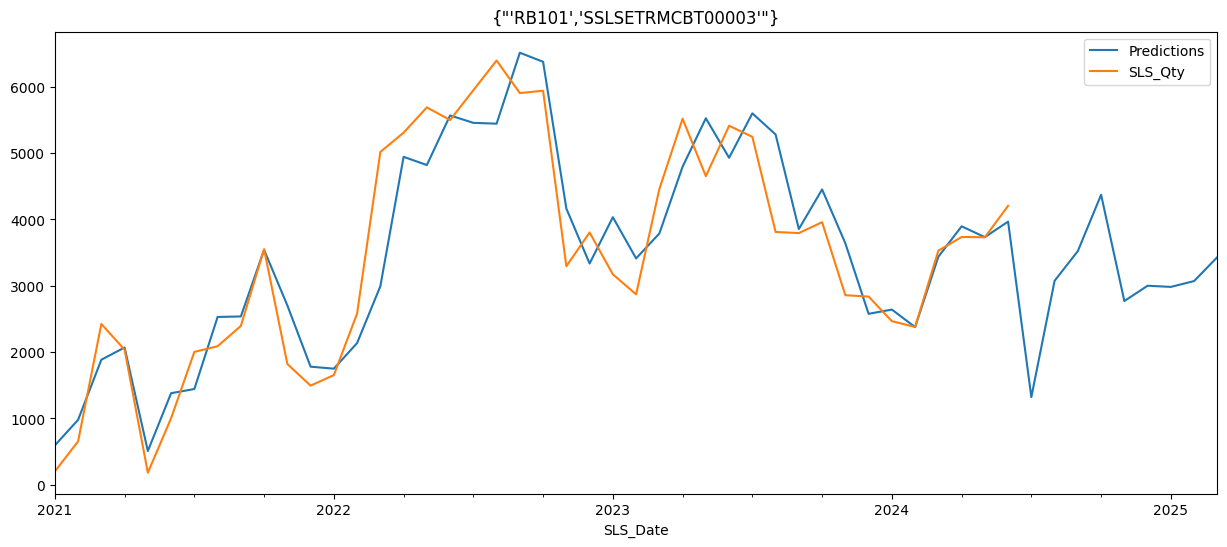

In [0]:
start = 0
end = len(sales_train) + len(sales_test) -1
  
# Predictions for one-year against the test set
predictions = model.predict(start, end,
                             typ = 'levels', exog = reg_test).rename("Predictions").to_frame()
  
# plot predictions and actual values
predictions.plot(figsize=(15,6))
monthly_df['SLS_Qty'][:-9].plot(legend = True)
plt.title({Style})

In [0]:
predictions['actual'] = monthly_df['SLS_Qty']
predictions['actual'] = predictions['actual'].fillna(0)
predictions['Predictions'] = np.round(predictions['Predictions'])
predictions['mape'] = (np.abs(predictions['actual']-predictions['Predictions'])/predictions['actual'])*100
predictions['mape'][-9:] = 0
predictions[-15:] 

,Predictions,actual,mape
2024-01-31,2641.0,2466.0,7.096513
2024-02-29,2377.0,2379.0,0.084069
2024-03-31,3438.0,3529.0,2.578634
2024-04-30,3896.0,3735.0,4.310576
2024-05-31,3733.0,3731.0,0.053605
2024-06-30,3967.0,4205.0,5.659929
2024-07-31,1321.0,153.0,0.000000
2024-08-31,3075.0,0.0,0.000000
2024-09-30,3523.0,0.0,0.000000
2024-10-31,4371.0,0.0,0.000000


In [0]:
predictions[-15:-10]['mape'].mean()

2.824679249802119

## Significant Variables


In [0]:
# # Get p-values from model results
# p_values = pd.DataFrame(model.pvalues)
# p_values = p_values.sort_values(by=0)
# p_values = p_values.reset_index()

In [0]:
# # Extract significant variables based on p-value less than 0.05
# insig_var = p_values[p_values[0]>0.1]
# insig_var = insig_var[insig_var.columns[0]].tolist()

# # Filter out insignificant variables
# sig_var = [var for var in reg_train.columns if not any(term in var for term in insig_var)]
# sig_var

In [0]:
## Provide Data of Training and Testing -- Data for training and testing

In [0]:
# %%capture
# %%time
# # Rebuild model using only significant variables without the excluded terms
# sig_reg_train = reg_train[sig_var] 
# sig_reg_test_optuna = reg_test_optuna[sig_var] 
# sig_reg_test = reg_test[sig_var] 

# if sig_var == []:
#   #Optuna
#   def objective_sarima(trial):
#       order=trial.suggest_categorical('order',pdq)
#       seasonal_order=trial.suggest_categorical('seasonal_order',pdqs)
#       sig_model = SARIMAX(sales_train['SLS_Qty'], 
#                   order = order, 
#                   seasonal_order = seasonal_order
#                   ).fit()
#       start = len(sales_train)
#       end = len(sales_train) + 5
        
#       sig_predictions = sig_model.predict(start, end,
#                                     typ = 'levels').to_frame()

#       residuals = np.abs(sales_test_optuna['SLS_Qty'] - sig_predictions['predicted_mean']).to_frame()
#       mape  = (residuals[0]/sales_test_optuna['SLS_Qty'])*100
#       mape=mape[-15:].mean()
#       return mape
#   study=optuna.create_study(direction="minimize")
#   study.optimize(objective_sarima,n_trials=100)
#   best_parameter = study.best_params
#   print(best_parameter)

#   # Fit a SARIMAX on the training set
#   sig_model = SARIMAX(sales_train['SLS_Qty'], 
#                 order = best_parameter['order'], 
#                 seasonal_order = best_parameter['seasonal_order']
#                 ).fit()
  
#   print(sig_model.summary())

# else:
#   #Optuna
#   def objective_sarima(trial):
#       order=trial.suggest_categorical('order',pdq)
#       seasonal_order=trial.suggest_categorical('seasonal_order',pdqs)
#       sig_model = SARIMAX(sales_train['SLS_Qty'], 
#                   order = order, 
#                   seasonal_order = seasonal_order,
#                   exog = sig_reg_train
#                   ).fit()
#       start = len(sales_train)
#       end = len(sales_train) + 5
        
#       sig_predictions = sig_model.predict(start, end,
#                                     typ = 'levels', exog = sig_reg_test_optuna).to_frame()

#       residuals = np.abs(sales_test_optuna['SLS_Qty'] - sig_predictions['predicted_mean']).to_frame()
#       mape  = (residuals[0]/sales_test_optuna['SLS_Qty'])*100
#       mape=mape[-15:].mean()
#       return mape
#   study=optuna.create_study(direction="minimize")
#   study.optimize(objective_sarima,n_trials=100)
#   best_parameter = study.best_params
#   print(best_parameter)

#   # Fit a SARIMAX on the training set
#   sig_model = SARIMAX(sales_train['SLS_Qty'], 
#                   order = best_parameter['order'], 
#                   seasonal_order = best_parameter['seasonal_order'],
#                   exog = sig_reg_train
#                   ).fit()

#   print(sig_model.summary());

In [0]:
# if sig_var == []:
#   start = 0
#   end = len(sales_train) + len(sales_test) -1
    
#   # Predictions for one-year against the test set
#   sig_predictions = sig_model.predict(start, end,
#                               typ = 'levels').rename("Predictions").to_frame()
    
#   # plot predictions and actual values
#   sig_predictions.plot(figsize=(15,6))
#   monthly_df['SLS_Qty'][:-10].plot(legend = True)

# else:
#   start = 0
#   end = len(sales_train) + len(sales_test) -1
    
#   # Predictions for one-year against the test set
#   sig_predictions = sig_model.predict(start, end,
#                               typ = 'levels', exog = sig_reg_test).rename("Predictions").to_frame()
    
#   # plot predictions and actual values
#   sig_predictions.plot(figsize=(15,6))
#   monthly_df['SLS_Qty'][:-10].plot(legend = True)

In [0]:
# sig_predictions['actual'] = monthly_df['SLS_Qty']
# sig_predictions['actual'] = sig_predictions['actual'].fillna(0)
# sig_predictions['Predictions'] = np.round(sig_predictions['Predictions'])
# sig_predictions['mape'] = (np.abs(sig_predictions['actual']-sig_predictions['Predictions'])/sig_predictions['actual'])*100
# sig_predictions['mape'][-10:] = 0
# sig_predictions[-15:]

In [0]:
# sig_predictions[-15:-10]['mape'].mean()

In [0]:
# if sig_predictions[-15:-10]['mape'].mean() < predictions[-15:-10]['mape'].mean():
#   best_preds = sig_predictions.copy()
# else:
#   best_preds = predictions.copy()

In [0]:
# best_preds.tail(15)

In [0]:
# # best_preds
# result = best_preds[-15:]
# result = result.reset_index()
# result = result.rename(columns={ result.columns[0]: "Date" })
# result

In [0]:
# result[-15:-10]['mape'].mean()

In [0]:
# import os

In [0]:
# # Save graph
# plt.figure(figsize=(15, 6))
# plt.title({Style})
# plt.plot(best_preds['Predictions'], label='Predictions')
# plt.plot(best_preds['actual'][:-7], label='Actual')
# plt.legend()

In [0]:

# if not os.path.exists("/FileStore/Pantaloons_Sales_Forecasting/Core Reordering PLM/{}/".format(Style)):
#     dbutils.fs.mkdirs("/FileStore/Pantaloons_Sales_Forecasting/Core Reordering PLM/{}/".format(Style))

# plt.savefig("/dbfs/FileStore/Pantaloons_Sales_Forecasting/Core Reordering PLM/{}/.png".format(Style), format='png')

In [0]:

# # Save csv
# # Create a folder for each result
# result_file_path = "/FileStore/Pantaloons_Sales_Forecasting/Core Reordering PLM/{}/".format(Style)  # Change the path accordingly

# # Check if the folder exists, if not, create it
# if not os.path.exists(result_file_path):
#     dbutils.fs.mkdirs(result_file_path)

# # Export file to the result folder
# file_name = "{}.csv".format(Style)  # Include the missing replacement value
# file_content = result.to_csv(index=False)  # Convert dataframe to string
# # Replace with the actual content you want to export

# # Export file to the result folder
# file_path = result_file_path + file_name

# dbutils.fs.put(file_path, file_content, overwrite=True)

In [0]:
# dbutils.notebook.exit(result)

In [0]:
# Check data for upto next march, April 2024 